# Setup

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import IPython.display as ipd
import sklearn as skl
import pandas as pd
from PIL import Image
import seaborn as sns
import sys

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 

from torcheval.metrics.metric import Metric
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from torcheval.metrics import MulticlassAccuracy
from torcheval.metrics import MulticlassPrecision
from torcheval.metrics import MulticlassRecall
from torcheval.metrics import MulticlassConfusionMatrix
from torcheval.metrics import MulticlassF1Score

from torcheval.metrics import BinaryAccuracy
from torcheval.metrics import BinaryPrecision
from torcheval.metrics import BinaryRecall
from torcheval.metrics import BinaryConfusionMatrix
from torcheval.metrics import BinaryF1Score

from torcheval.metrics.functional import mean_squared_error

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
gtzan_dir = Path(str(os.environ.get('GTZAN_DIR')))   #C:/VisualStudioRepositories/MUSIC_DATA/gt/Data
fma_dir = Path(str(os.environ.get('FMA_DIR')))       #C:/VisualStudioRepositories/MUSIC_DATA/fma

gtzan_image_dir = gtzan_dir / 'spectrograms'
gtzan_df_path = gtzan_dir / 'gtzan_df.csv'

fma_small_image_dir = fma_dir / 'spectrograms/fma_small'
fma_medium_image_dir = fma_dir / 'spectrograms/fma_medium'
fma_df_path = fma_dir / 'fma_df.csv'

In [4]:
report_output_root_dir = Path('../output/txt')

report_output_dirs = {'gtzan_multi': report_output_root_dir / 'gtzan_multi',
                      'fma_small_multi': report_output_root_dir / 'fma_small_multi',
                      'fma_medium_multi': report_output_root_dir / 'fma_medium_multi',
                      
                      'gtzan_binary': report_output_root_dir / 'gtzan_binary',
                      'fma_small_binary': report_output_root_dir / 'fma_small_binary',
                      'fma_medium_binary': report_output_root_dir / 'fma_medium_binary'}

In [5]:
gtzan_classes = ['Blues', 'Classical', 'Country', 'Disco', 'Hip-Hop', 'Jazz', 'Metal', 'Pop', 'Reggae', 'Rock'] #10

fma_small_top_classes = ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock'] #8

fma_medium_top_classes = ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock',
                          'Easy Listening', 'Blues', 'Soul-RnB', 'Spoken', 'Country', 'Jazz', 'Old-Time / Historic', 'Classical'] #16

In [6]:
IMAGE_SIZE = 128    #128x128 px images for the CNN (with 3 channels)

# Clean output directories

Content of subfolders is intentionally NOT cleaned. This way, interesting results can be persisted if they have a dedicated subfolder.

In [108]:
for dir_path in report_output_dirs.values():
    for file_path in dir_path.glob('*.txt'):
        file_path.unlink()
    for file_path in dir_path.glob('*.png'):
        file_path.unlink()

# Define function loading GTZAN df from file

In [7]:
def get_gtzan_dataframe(with_val):
    gtzan_df = pd.read_csv(gtzan_df_path)
    
    # turn relative paths into absolute paths
    gtzan_df['path'] = gtzan_df['path'].apply(lambda x: gtzan_image_dir / x)
    
    # SAMPLES: 800/98/100
    if (with_val):
        gtzan_train_df = gtzan_df[gtzan_df['set'] == 'train']
        gtzan_val_df = gtzan_df[gtzan_df['set'] == 'validation']
        gtzan_test_df = gtzan_df[gtzan_df['set'] == 'test']
        return gtzan_train_df, gtzan_val_df, gtzan_test_df
    else: # SAMPLES: 800/198
        gtzan_train_df = gtzan_df[gtzan_df['set'] == 'train']
        gtzan_test_df = gtzan_df[(gtzan_df['set'] == 'test') | (gtzan_df['set'] == 'validation')]
        return gtzan_train_df, gtzan_test_df

# Load GTZAN df (with/without separate val set)

In [8]:
# with separate val
gtzan_train_df, gtzan_val_df, gtzan_test_df = get_gtzan_dataframe(with_val=True)

In [9]:
# without separate val
gtzan_train_df, gtzan_test_df = get_gtzan_dataframe(with_val=False)

# Define function loading FMA df from file

In [7]:
def get_fma_dataframe(get_fma_small, with_val):
    fma_df = pd.read_csv(fma_df_path)
    
    # turn relative paths into absolute paths
    fma_df['path'] = fma_df['path'].apply(lambda x: fma_medium_image_dir / x)
    
    # otherwise the dataset is FMA-medium
    if (get_fma_small):
        fma_df = fma_df[fma_df['size'] == 'small']
    
    # PERCENTAGES: 80/10/10
    if (with_val):
        fma_train_df = fma_df[fma_df['set'] == 'training']
        fma_val_df = fma_df[fma_df['set'] == 'validation']
        fma_test_df = fma_df[fma_df['set'] == 'test']
        return fma_train_df, fma_val_df, fma_test_df
    else: # PERCENTAGES: 80/20
        fma_train_df = fma_df[fma_df['set'] == 'training']
        fma_test_df = fma_df[(fma_df['set'] == 'test') | (fma_df['set'] == 'validation')]
        return fma_train_df, fma_test_df

# Load FMA df (with/without separate val set) (small/medium)

In [8]:
# fma-small with separate val
fma_small_train_df, fma_small_val_df, fma_small_test_df = get_fma_dataframe(get_fma_small=True, with_val=True)

In [ ]:
# fma-small without separate val
fma_small_train_df, fma_small_test_df = get_fma_dataframe(get_fma_small=True, with_val=False)

In [8]:
# fma-medium with separate val
fma_medium_train_df, fma_medium_val_df, fma_medium_test_df = get_fma_dataframe(get_fma_small=False, with_val=True)

In [ ]:
# fma-medium without separate val
fma_medium_train_df, fma_medium_test_df = get_fma_dataframe(get_fma_small=False, with_val=False)

# Define input data loading functions - PyTorch

In [45]:
# 0, 1, 2, 3... labels used with nn.CrossEntropyLoss
def numerically_encode_class_label(class_name, available_classes):
  return available_classes.index(class_name)

# currently unused
def one_hot_encode_class_label(class_name, available_classes):
  label = available_classes.index(class_name)
  one_hot = np.zeros(len(available_classes))
  one_hot[label] = 1
  return one_hot

# decode png
def decode_img_data(img_path, channels=3):
  img = Image.open(img_path).convert('RGB' if channels == 3 else 'L') # convert to RGB if 3 channels, otherwise grayscale
  img = img.resize((IMAGE_SIZE, IMAGE_SIZE))
  img = np.array(img)
  img = torch.tensor(img).permute(2, 0, 1) if channels == 3 else torch.tensor(img).unsqueeze(0) # channels first
  return img.float() / 255.0 # normalize to [0, 1]

# return pair: decoded png and class name turned into numerical label
def process_sample(sample, available_classes, channels=3):
  img_path = sample[0]
  class_label = sample[1]
  
  img_data = decode_img_data(img_path, channels)
  numerical_label = numerically_encode_class_label(class_label, available_classes)
  return img_data, numerical_label

In [46]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, df, available_classes, channels=3):
        self.df = df
        self.available_classes = available_classes
        self.channels = channels

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['path']
        class_label = self.df.iloc[idx]['genre']
        img_data, numerical_label = process_sample((img_path, class_label), self.available_classes, self.channels)
        return img_data.to(device), torch.tensor(numerical_label, device=device) #! DATA on device

def prepare_dataloader_based_on_df(df, available_classes, batch_size=8, channels=3):
    dataset = CustomDataset(df, available_classes, channels)
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=0, shuffle=True)
    return dataloader

In [47]:
def visualize_samples_from_dataloader_batch(dl, available_classes, samples=6):
    image_batch, label_batch = next(iter(dl))
    samples = samples if samples <= len(label_batch) else len(label_batch)
    
    fig, axes = plt.subplots(ncols=3, nrows=(samples + 2) // 3)
    [axis.set_axis_off() for axis in axes.ravel()]
    
    for i in range(samples):
        ax = axes.flat[i]
        img = image_batch[i].permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C)
        ax.imshow(img)
        ax.set_title(available_classes[torch.argmax(label_batch[i]).item()])

# Create GTZAN DataLoaders

With val

In [13]:
BATCH_SIZE = 32
CHANNELS = 3

In [14]:
gtzan_train_dl = prepare_dataloader_based_on_df(gtzan_train_df, gtzan_classes, BATCH_SIZE, CHANNELS)
gtzan_val_dl = prepare_dataloader_based_on_df(gtzan_val_df, gtzan_classes, BATCH_SIZE, CHANNELS)
gtzan_test_dl = prepare_dataloader_based_on_df(gtzan_test_df, gtzan_classes, BATCH_SIZE, CHANNELS)

# Visualize GTZAN from DataLoader

Done on CPU

In [ ]:
visualize_samples_from_dataloader_batch(gtzan_test_dl, gtzan_classes, samples=6)

# CNN model - PyTorch

In [9]:
# 4 convolutional layers
# layer 1 and 2:
#   64 kernels 5x5 each,
#   RELU,
#   batch normalization,
#   2d max pooling - kernel size 2 stride 2
#   
# layer 3 and 4:
#   128 kernels 5x5 each,
#   RELU,
#   batch normalization,
#   2d max pooling - kernel size 2 stride 2
#
# dropout 0.2
#
# output:
#   fully connected linear layer

class CNN(nn.Module):
    def __init__(self, img_size, channels, num_outputs):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(channels, 64, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout = nn.Dropout(0.2)
        
        self.conv2 = nn.Conv2d(64, 64, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(128, 128, kernel_size=5, stride=1, padding=2)
        self.bn4 = nn.BatchNorm2d(128)
        
        # Calculate the size of the flattened feature map
        self.flattened_size = (img_size // 16) * (img_size // 16) * 128
        # max pooling reduces image width by /16 and image height by /16
        # 128 is the number of kernels in the last convolutional layer
        
        self.fc = nn.Linear(self.flattened_size, num_outputs) # Logits, not probabilities
        
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.dropout(x)
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout(x)
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.dropout(x)
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.dropout(x)
        
        x = x.view(-1, self.flattened_size)  # Flatten the feature map
        x = self.fc(x)
        
        return x

# Metrics - multiclass and binary

## Custom metrics

### Helper functions

In [10]:
# BINARY CLASSIFICATION (1 output neuron):
# logits -> sigmoid -> round -> predicted class indexes

# MULTI-CLASS CLASSIFICATION (N output neurons):
# logits -> argmax -> predicted classes indexes (softmax is optional but not necessary)
def get_predicted_classes(predictions, is_binary):  # threshold for binary = 0.5
    return [torch.round(torch.sigmoid(pred)) for pred in predictions] if is_binary else [torch.argmax(pred) for pred in predictions]
    
def get_predicted_probabilities(predictions, is_binary):
    return [torch.sigmoid(pred) for pred in predictions] if is_binary else [F.softmax(pred, dim=0) for pred in predictions]
    
def get_binary_labels_for_class(labels, class_index):
    return [1 if label == class_index else 0 for label in labels]

### Qualitative measures using base Scikit-learn implementation

In [11]:
# predicted: NUMERICAL CLASS LABELS (0, 1, 2, 3...)
# true: NUMERICAL CLASS LABELS (0, 1, 2, 3...)
class BinaryCohenKappa(Metric[torch.Tensor]):
    def __init__(self, is_binary, device = None) -> None:
        super().__init__(device=device)
        self.is_binary = is_binary
        self._add_state("true_classes", torch.tensor([], device=self.device)) 
        self._add_state("predicted_classes", torch.tensor([], device=self.device))

    @torch.inference_mode()
    def update(self, prediction_logits, labels):
        predicted = torch.tensor(get_predicted_classes(prediction_logits, self.is_binary), device=self.device)
        
        self.true_classes = torch.cat((self.true_classes, labels))
        self.predicted_classes = torch.cat((self.predicted_classes, predicted))
        return self

    @torch.inference_mode()
    def compute(self): 
        return cohen_kappa_score( self.true_classes.cpu().detach().numpy(), self.predicted_classes.cpu().detach().numpy() )

    @torch.inference_mode()
    def merge_state(self, metrics):
        true_classes_2 = [self.true_classes, ]
        predicted_classes_2 = [self.predicted_classes, ]
        
        for metric in metrics:
            true_classes_2.append(metric.true_classes_2)
            predicted_classes_2.append(metric.predicted_classes_2)
            self.true_classes = torch.cat(true_classes_2)
            self.predicted_classes = torch.cat(predicted_classes_2)
        return self

In [12]:
# predicted: NUMERICAL CLASS LABELS (0, 1, 2, 3...)
# true: NUMERICAL CLASS LABELS (0, 1, 2, 3...)
class MCC(Metric[torch.Tensor]):
    def __init__(self, is_binary, device = None) -> None:
        super().__init__(device=device)
        self.is_binary = is_binary
        self._add_state("true_classes", torch.tensor([], device=self.device)) 
        self._add_state("predicted_classes", torch.tensor([], device=self.device))

    @torch.inference_mode()
    def update(self, prediction_logits, labels):
        predicted = torch.tensor(get_predicted_classes(prediction_logits, self.is_binary), device=self.device)
        
        self.true_classes = torch.cat((self.true_classes, labels))
        self.predicted_classes = torch.cat((self.predicted_classes, predicted))
        return self

    @torch.inference_mode()
    def compute(self): 
        return torch.tensor(skl.metrics.matthews_corrcoef( self.true_classes.cpu().detach().numpy(), self.predicted_classes.cpu().detach().numpy() )).to(device)

    @torch.inference_mode()
    def merge_state(self, metrics):
        true_classes_2 = [self.true_classes, ]
        predicted_classes_2 = [self.predicted_classes, ]
        
        for metric in metrics:
            true_classes_2.append(metric.true_classes_2)
            predicted_classes_2.append(metric.predicted_classes_2)
            self.true_classes = torch.cat(true_classes_2)
            self.predicted_classes = torch.cat(predicted_classes_2)
        return self

### Rank measures - ROC

In [13]:
# SCIKIT INFORMATION:
# multiclass:
# raise-> used for binary classification, raises error when input is mistakenly multiclass.
# ovr  -> one vs REST (AUNu or AUNp)
#         Computes the AUC of each class against the rest. This treats the multiclass case in the same way as the multilabel case.
#         Sensitive to class imbalance even when average == 'macro', because class imbalance affects
#         the composition of each of the ‘rest’ groupings.         
# ovo  -> one vs ONE (AU1u or AU1p)
#         Computes the average AUC of all possible pairwise combinations of classes.
#         Insensitive to class imbalance when average == 'macro'.

# average:
# None     -> AUC score for each class. For multiclass: None implemented only for OVR
# macro    -> Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.
# micro    -> Calculate metrics globally by considering each element of the label indicator matrix as a label.
# weighted -> Calculate metrics for each label, and find their average,
#             weighted by support (the number of true instances for each label).
# samples  -> calculated for each sample

# combinations:
# raise + macro  ->    binary AUC
# ovr + macro    ->    AUNu
# ovr + weighted ->    AUNp
# ovo + macro    ->    AU1u
# ovo + weighted ->    AU1p
# ovr + None     ->    multiclass AUC per class (vs rest)

# predicted: PROBABILITIES (sigmoid for binary, softmax for multiclass)
# true: NUMERICAL CLASS LABELS (0, 1, 2, 3...)
class ROCAUC(Metric[torch.Tensor]):
    def __init__(self, multiclass, average, device = None) -> None:
        super().__init__(device=device)
        self.is_binary = multiclass == 'raise'
        self.multiclass = multiclass
        self.average = average
 
        self._add_state("true_classes", torch.tensor([], device=self.device)) 
        self._add_state("predicted_probabilities", torch.tensor([], device=self.device))

    @torch.inference_mode()
    def update(self, prediction_logits, labels):
        probabilities = torch.stack(get_predicted_probabilities(prediction_logits, self.is_binary)).clone().detach()      
        self.true_classes = torch.cat((self.true_classes, labels))
        self.predicted_probabilities = torch.cat((self.predicted_probabilities, probabilities))
        return self

    @torch.inference_mode()
    def compute(self):     
        return roc_auc_score(y_true=self.true_classes.cpu().detach().numpy(),
                             y_score=self.predicted_probabilities.cpu().detach().numpy(),
                             multi_class=self.multiclass,
                             average=self.average)

    @torch.inference_mode()
    def merge_state(self, metrics):
        true_classes_2 = [self.true_classes, ]
        predicted_probabilities_2 = [self.predicted_probabilities, ]
        
        for metric in metrics:
            true_classes_2.append(metric.true_classes_2)
            predicted_probabilities_2.append(metric.predictions_2)
            self.true_classes = torch.cat(true_classes_2)
            self.predicted_probabilities = torch.cat(predicted_probabilities_2)
        return self

In [14]:
drawn_binary_ROC = 'drawn_binary_ROC'
drawn_multi_ROC = 'drawn_multi_ROC'
drawn_AUNu = 'drawn_AUNu'
drawn_ROC_list = [drawn_binary_ROC, drawn_multi_ROC, drawn_AUNu]

In [15]:
# used just to draw the ROC curve, roc_curve does not have the same built-in options roc_curve_score does

# predicted: PROBABILITIES (sigmoid for binary, softmax for multiclass)
# true: NUMERICAL CLASS LABELS (0, 1, 2, 3...)
class drawn_ROC_curve(Metric[torch.Tensor]):
    def __init__(self, n_classes, device = None) -> None:
        super().__init__(device=device)
        
        self.is_binary = n_classes == 2
        self.n_classes = n_classes
        self._add_state("true_classes", torch.tensor([], device=self.device)) 
        self._add_state("predicted_probabilities", torch.tensor([], device=self.device))

    @torch.inference_mode()
    def update(self, prediction_logits, labels):
        probabilities = torch.stack(get_predicted_probabilities(prediction_logits, self.is_binary)).clone().detach()      
        self.true_classes = torch.cat((self.true_classes, labels))
        self.predicted_probabilities = torch.cat((self.predicted_probabilities, probabilities))       
        return self
    
    # FPR - x axis, TPR - y axis on the ROC curve
    @torch.inference_mode()
    def calculate_roc_FPR_TPR_pairs(self):
        if self.is_binary:
            fprs, tprs, _ = roc_curve(y_true=self.true_classes.cpu().detach().numpy(), y_score=self.predicted_probabilities.cpu().detach().numpy())
            return fprs, tprs
        
        # calculate TPR and FPR pairs for each class
        fprs, tprs = dict(), dict()
        for i in range(self.n_classes):
            binary_labels_for_class = get_binary_labels_for_class(self.true_classes.cpu().detach().numpy(), i)
            fprs[i], tprs[i], _ = roc_curve(y_true=binary_labels_for_class, y_score=self.predicted_probabilities[:, i].cpu().detach().numpy())
        return fprs, tprs
        
    # implemented in subclasses
    @torch.inference_mode()
    def compute(self):  
        pass

    @torch.inference_mode()
    def merge_state(self, metrics):
        true_classes_2 = [self.true_classes, ]
        predicted_probabilities_2 = [self.predicted_probabilities, ]
        
        for metric in metrics:
            true_classes_2.append(metric.true_classes_2)
            predicted_probabilities_2.append(metric.predictions_2)
            self.true_classes = torch.cat(true_classes_2)
            self.predicted_probabilities = torch.cat(predicted_probabilities_2)
        return self

In [16]:
class drawn_binary_ROC_curve(drawn_ROC_curve):
    def __init__(self, device = None) -> None:
        super().__init__(n_classes=2, device=device)

    @torch.inference_mode()
    def compute(self):  
        return super().calculate_roc_FPR_TPR_pairs()

In [17]:
# one vs rest, macro average
class drawn_AUNu_curve(drawn_ROC_curve):
    def __init__(self, n_classes, device = None) -> None:
        super().__init__(n_classes=n_classes, device=device)

    # 
    @torch.inference_mode()
    def compute(self):  
        fprs, tprs = super().calculate_roc_FPR_TPR_pairs()

        fpr_grid = np.linspace(0.0, 1.0, 1000)
        mean_tpr = np.zeros_like(fpr_grid)

        for i in range(self.n_classes):
            mean_tpr += np.interp(fpr_grid, fprs[i], tprs[i])  # linear interpolation

        mean_tpr /= self.n_classes  
        return fpr_grid, mean_tpr

In [18]:
# one vs rest, separate AUC for each class
class drawn_multi_ROC_curve(drawn_ROC_curve):
    def __init__(self, n_classes, device = None) -> None:
        super().__init__(n_classes, device)

    @torch.inference_mode()
    def compute(self):  
        return super().calculate_roc_FPR_TPR_pairs()

### Probabilistic measures

In [19]:
# predicted: PROBABILITIES
# true: 0/1 if binary, one-hot encoded if multiclass
class MSE(Metric[torch.Tensor]):
    def __init__(self, num_classes, device = None) -> None:
        super().__init__(device=device)
        self.is_binary = num_classes == 2
        self.n_classes = num_classes
        self._add_state("true_classes", torch.tensor([], device=self.device)) 
        self._add_state("predicted_probabilities", torch.tensor([], device=self.device))

    @torch.inference_mode()
    def update(self, prediction_logits, labels):
        true = labels.float() if self.is_binary else F.one_hot(labels, num_classes=self.n_classes).float()
        probabilities = torch.stack(get_predicted_probabilities(prediction_logits, self.is_binary)).clone().detach()
        
        self.true_classes = torch.cat((self.true_classes, true))
        self.predicted_probabilities = torch.cat((self.predicted_probabilities, probabilities))
        return self

    @torch.inference_mode()
    def compute(self): 
        return mean_squared_error( self.predicted_probabilities, self.true_classes )

    @torch.inference_mode()
    def merge_state(self, metrics):
        true_classes_2 = [self.true_classes, ]
        predicted_probabilities_2 = [self.predicted_probabilities, ]
        
        for metric in metrics:
            true_classes_2.append(metric.true_classes_2)
            predicted_probabilities_2.append(metric.predicted_probabilities_2)
            self.true_classes = torch.cat(true_classes_2)
            self.predicted_probabilities = torch.cat(predicted_probabilities_2)
        return self

In [20]:
# predicted: LOGITS
# true: NUMERICAL CLASS LABELS (0, 1, 2, 3...)
class LogLoss(Metric[torch.Tensor]):
    def __init__(self, num_classes, device = None) -> None:
        super().__init__(device=device)
        self.is_binary = num_classes == 2
        self.n_classes = num_classes
        self._add_state("true_classes", torch.tensor([], device=self.device)) 
        self._add_state("predicted_logits", torch.tensor([], device=self.device))

    @torch.inference_mode()
    def update(self, logits, numerical_labels):        
        self.true_classes = torch.cat((self.true_classes, numerical_labels))
        self.predicted_logits = torch.cat((self.predicted_logits, logits))
        return self

    @torch.inference_mode()
    def compute(self): 
        if self.is_binary:
            loss = nn.BCEWithLogitsLoss()
            numerical_labels = self.true_classes
        else:
            loss = nn.CrossEntropyLoss()
            numerical_labels = self.true_classes.type(torch.LongTensor).to(device)
        
        return loss(self.predicted_logits, numerical_labels)

    @torch.inference_mode()
    def merge_state(self, metrics):
        true_classes_2 = [self.true_classes, ]
        predicted_logits_2 = [self.predicted_logits, ]
        
        for metric in metrics:
            true_classes_2.append(metric.true_classes_2)
            predicted_logits_2.append(metric.predicted_logits_2)
            self.true_classes = torch.cat(true_classes_2)
            self.predicted_logits = torch.cat(predicted_logits_2)
        return self

### Qualitative measures using direct Matrix calculations

In [21]:
# base class for custom metrics that use TP, TN, FP, FN values directly:
# > multiclass Cohen's Kappa
# > multiclass MCC
# > macro-accuracy, micro-accuracy, accuracy per class

# LOGITS
# NUMERICAL LABELS
class MatrixMetric(Metric[torch.Tensor]):
    def __init__(self, num_classes, device = None) -> None:
        super().__init__(device=device)
        
        self.is_binary = num_classes == 2
        self.num_classes = num_classes
        self._add_state("true_classes", torch.tensor([], device=self.device)) 
        self._add_state("predicted_logits", torch.tensor([], device=self.device))
        
    @torch.inference_mode()
    def update(self, logits, numerical_labels):        
        self.true_classes = torch.cat((self.true_classes, numerical_labels))
        self.predicted_logits = torch.cat((self.predicted_logits, logits))
        return self
    
    @torch.inference_mode()
    def calculate_matrix(self):
        numerical_labels_int = self.true_classes.to(torch.int64)       
        matrix_metric = MulticlassConfusionMatrix(self.num_classes)
        matrix_metric.update(input=self.predicted_logits, target=numerical_labels_int)
        return matrix_metric.compute()
    
    @torch.inference_mode()
    def calculate_TPs_FPs_FNs_TNs_for_class(self, matrix, class_index):
        TP = matrix[class_index, class_index]   # one cell
        FP = matrix[:, class_index].sum() - TP  # same column without the TP
        FN = matrix[class_index, :].sum() - TP  # same row without the TP
        TN = matrix.sum() - TP - FP - FN        # rest
        return TP, FP, FN, TN
    
    @torch.inference_mode()
    def calculate_TPs_FPs_FNs_TNs_for_each_class(self):
        matrix_results = self.calculate_matrix()
        
        TPs, FPs, FNs, TNs = [], [], [], []
        for i in range(self.num_classes):
            TP, FP, FN, TN = self.calculate_TPs_FPs_FNs_TNs_for_class(matrix_results, i)
            TPs.append(TP), FPs.append(FP), FNs.append(FN), TNs.append(TN)
        return TPs, FPs, FNs, TNs
    
    # implemented in subclasses
    @torch.inference_mode()
    def compute(self):  
        pass

    @torch.inference_mode()
    def merge_state(self, metrics):
        true_classes_2 = [self.true_classes, ]
        predicted_probabilities_2 = [self.predicted_probabilities, ]
        
        for metric in metrics:
            true_classes_2.append(metric.true_classes_2)
            predicted_probabilities_2.append(metric.predictions_2)
            self.true_classes = torch.cat(true_classes_2)
            self.predicted_probabilities = torch.cat(predicted_probabilities_2)
        return self
    

In [22]:
class MacroAccuracy(MatrixMetric):
    def __init__(self, num_classes, device = None) -> None:
        super().__init__(num_classes=num_classes, device=device)

    @torch.inference_mode()
    def compute(self): 
        TPs, FPs, FNs, TNs = self.calculate_TPs_FPs_FNs_TNs_for_each_class()
        accuracies_for_each_class = [(TP + TN) / (TP + FP + FN + TN) for TP, TN, FP, FN in zip(TPs, TNs, FPs, FNs)]
        return sum(accuracies_for_each_class) / self.num_classes

In [23]:
class MicroAccuracy(MatrixMetric):
    def __init__(self, num_classes, device = None) -> None:
        super().__init__(num_classes=num_classes, device=device)

    @torch.inference_mode()
    def compute(self): 
        TPs, FPs, FNs, TNs = self.calculate_TPs_FPs_FNs_TNs_for_each_class()      
        total_TP = sum(TPs)
        total_FP = sum(FPs)
        total_FN = sum(FNs)
        total_TN = sum(TNs)
        return (total_TP + total_TN) / (total_TP + total_FP + total_FN + total_TN)

In [24]:
class AccuracyPerClass(MatrixMetric):
    def __init__(self, num_classes, device = None) -> None:
        super().__init__(num_classes=num_classes, device=device)

    @torch.inference_mode()
    def compute(self): 
        TPs, FPs, FNs, TNs = self.calculate_TPs_FPs_FNs_TNs_for_each_class()
        accuracies_for_each_class = [(TP + TN) / (TP + FP + FN + TN) for TP, TN, FP, FN in zip(TPs, TNs, FPs, FNs)]
        return torch.tensor(accuracies_for_each_class).to(self.device)

In [25]:
class MulticlassCohenKappa(MatrixMetric):
    def __init__(self, num_classes, device = None) -> None:
        super().__init__(num_classes=num_classes, device=device)

    @torch.inference_mode()
    def compute(self): 
        matrix = self.calculate_matrix()
        
        n = matrix.sum()
        matrix_diag_sum = matrix.diag().sum()
        matrix_cols = [matrix[:, i].sum() for i in range(self.num_classes)]
        matrix_rows = [matrix[i, :].sum() for i in range(self.num_classes)]
        
        p0 = matrix_diag_sum / n
        pe = sum([matrix_cols[i] * matrix_rows[i] for i in range(self.num_classes)]) / (n * n)
        
        cohens_kappa = (p0 - pe) / (1 - pe)
        return torch.tensor(cohens_kappa).to(self.device)

## Metric calculation verification

Converter tests

In [26]:
# GET_PREDICTED_CLASSES
# mutliclass

# 3 elements in batch, 4 classes with indexes 0-3
logits = torch.tensor([[0.1, 0.2, 0.7, 0.1],
                       [0.3, 0.4, 0.3, 0.25],
                       [0.5, 0.3, 0.2, 0.11]])
expected_results = [2,
                    1,
                    0]
results = get_predicted_classes(logits, is_binary=False)
assert results == expected_results

# binary

# 5 elements in batch, index 1 is positive class
# threshold when used on probability: 0.5
# threshold when used on logits: 0
logits = torch.tensor([[-7],
                       [-0.2],
                       [10],
                       [0.5],
                       [-4]])
expected_results = [0,
                    0,
                    1,
                    1,
                    0]
results = get_predicted_classes(logits, is_binary=True)
assert results == expected_results

todo: verify converters and metrics by comparing to hand calculations

## Metric sets

Macro - equal weight to every class

Micro - more samples -> bigger influence

In [27]:
# Basic metric set calculated and displayed:
# - EVERY TRAINING loop
# - EVERY VALIDATION loop.
# Its metrics are included in the full metric set.
def create_basic_multiclass_metrics(num_classes):
    return {
                "macro_accuracy": MacroAccuracy(device=device, num_classes=num_classes),
                "macro_recall": MulticlassRecall(device=device, average='macro', num_classes=num_classes),  
                "macro_precision": MulticlassPrecision(device=device, average='macro', num_classes=num_classes),
                "macro_f1": MulticlassF1Score(device=device, average='macro', num_classes=num_classes), 
                
                "precision_per_class": MulticlassPrecision(device=device, average=None, num_classes=num_classes),
                "recall_per_class": MulticlassRecall(device=device, average=None, num_classes=num_classes), 
            }
    
# Full metric set (contains basic set) calculated and displayed on:
# - LAST VALIDATION loop
# - TEST loop
# This is done to reduce clutter in the output and to calculate the full metric set
# only when the results are most useful.
def create_full_multiclass_metrics(num_classes):
    return { 
             "macro_accuracy": MacroAccuracy(device=device, num_classes=num_classes),
             "micro_accuracy": MicroAccuracy(device=device, num_classes=num_classes),
             "accuracy_per_class": AccuracyPerClass(device=device, num_classes=num_classes),
            
             "macro_f1": MulticlassF1Score(device=device, average='macro', num_classes=num_classes), 
             "micro_f1": MulticlassF1Score(device=device, average='micro'),
             "f1_per_class": MulticlassF1Score(device=device, average=None, num_classes=num_classes),
            
             "macro_precision": MulticlassPrecision(device=device, average='macro', num_classes=num_classes),
             "micro_precision": MulticlassPrecision(device=device, average='micro'),
             "precision_per_class": MulticlassPrecision(device=device, average=None, num_classes=num_classes),
             
             "macro_recall": MulticlassRecall(device=device, average='macro', num_classes=num_classes),
             "micro_recall": MulticlassRecall(device=device, average='micro'),
             "recall_per_class": MulticlassRecall(device=device, average=None, num_classes=num_classes), 
             
             "Cohen's Kappa": MulticlassCohenKappa(device=device, num_classes=num_classes),
             "MCC": MCC(device=device, is_binary=False),
             
             # Probabilistic metrics
             "MSE": MSE(device=device, num_classes=num_classes),
             "LogLoss": LogLoss(device=device, num_classes=num_classes),
             
             # Rank metrics
             "AUNu": ROCAUC(device=device, multiclass='ovr', average='macro'),
             "AUNp": ROCAUC(device=device, multiclass='ovr', average='weighted'),
             "AU1u": ROCAUC(device=device, multiclass='ovo', average='macro'),
             "AU1p": ROCAUC(device=device, multiclass='ovo', average='weighted'),
             "ROC-AUC_per_class_vs_rest": ROCAUC(device=device, multiclass='ovr', average=None),
             
             drawn_AUNu: drawn_AUNu_curve(device=device, n_classes=num_classes),
             drawn_multi_ROC: drawn_multi_ROC_curve(device=device, n_classes=num_classes),
             
             # Confusion Matrix displayed last
             "confusion_matrix": MulticlassConfusionMatrix(device=device, num_classes=num_classes),
             }
    
# ROC-AUC using TorchEval:
#"AUNU": MulticlassAUROC(device=device, average="macro", num_classes=num_classes), # ONE vs REST, macro average
#"ROC-AUC_per_class": MulticlassAUROC(device=device, average=None, num_classes=num_classes),    
# Scikit was chosen because it has more averaging options and can be used to draw curves

Binary metrics

In [28]:
# thresholds are 0 because the outputs are logits
def create_basic_binary_metrics():
    return { "accuracy": BinaryAccuracy(device=device, threshold=0),
             "f1": BinaryF1Score(device=device, threshold=0),   
            }
    
def create_full_binary_metrics():
    basic_metrics = create_basic_binary_metrics()
    return { **basic_metrics,
                     
              "precision": BinaryPrecision(device=device, threshold=0),         
              "recall": BinaryRecall(device=device, threshold=0),                     
              "cohen's kappa": BinaryCohenKappa(device=device, is_binary=True),
              "MCC": MCC(device=device, is_binary=True),
              
              # Probabilistic metrics
               "MSE": MSE(device=device, num_classes=2),
               "LogLoss": LogLoss(device=device, num_classes=2),
              
              # Rank metrics
              "binary_ROC-AUC": ROCAUC(device=device, multiclass='raise', average='macro'),
              drawn_binary_ROC: drawn_binary_ROC_curve(device=device),
                  
              # Confusion Matrix displayed last
              "confusion_matrix": BinaryConfusionMatrix(device=device, threshold=0),
           }
    # PyEval:
    #"ROC-AUC": BinaryAUROC(device=device)

Note:

issue https://github.com/pytorch/torcheval/pull/199 for TorchEval mentions that the warning message for MulticlassPrecision(average=None) is misleading.

The warning says that both the ground truth AND predictions have n=0 for some classes, but in fact it takes only ground truth OR predictions to have n=0 for this warning to appear. So, if a model just never predicts a particular class in an epoch, this warning appears despite it not being an architectural mistake.

BCEWithLogitsLoss - turns out that it needs: outputs.squeeze(), labels.float()


## Display metrics

In [29]:
# can be binary or multiclass
def draw_confusion_matrix(confusion_matrix, class_names, file_output=None):
    plt.figure(figsize=(10, 10))
    sns.heatmap(confusion_matrix, annot=True, cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar=True, square=True, linewidths=0, linecolor='black',
                fmt='g')  # 'g' format ensures no scientific notation

    plt.title('Confusion Matrix')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    
    if file_output is not None:
        plt.savefig(file_output)
       
    plt.show()

In [30]:
def render_roc(ax, roc_curve, color="navy", label=None):
    fpr, tpr = roc_curve[0], roc_curve[1]
    ax.plot(
        fpr,
        tpr,
        color=color,
        linewidth=2,
        label=label
    )

def draw_binary_ROC_curve(ax, roc_curve):
    ax.set_title("ROC curve")
    render_roc(ax, roc_curve)
    
def draw_multi_ROC_curve(ax, roc_curve, class_names):
    ax.set_title("ROC curves, one vs rest")
    colors = plt.cm.get_cmap('tab10', len(class_names))
    for i in range(len(class_names)):
        render_roc(ax, (roc_curve[0][i], roc_curve[1][i]), color=colors(i), label=class_names[i])
    ax.legend(loc='lower right')
    
def draw_AUNu_curve(ax, roc_curve):
    ax.set_title("AU1u (one vs rest, macro average)")
    render_roc(ax, roc_curve)

def draw_roc_curve(roc_curve, roc_type, class_names=None, file_output=None):
    fig, ax = plt.subplots(figsize=(6,6))
    
    if roc_type == drawn_binary_ROC:
        draw_binary_ROC_curve(ax, roc_curve)
    elif roc_type == drawn_multi_ROC:
        draw_multi_ROC_curve(ax, roc_curve, class_names)
    elif roc_type == drawn_AUNu:
        draw_AUNu_curve(ax, roc_curve)
    
    if file_output is not None:
        plt.savefig(file_output)
        
    #plt.show(fig)

In [31]:
def print_single_metric(name, value, output=sys.stdout):
    print(f"{name}: {value:.4f}", file=output)
    
def print_metric_per_class(name, values, class_names, output=sys.stdout):
    print(f"{name}:", end=" ", file=output)
    [print(f"{class_names[i]}: {values[i]:.4f}", end=" ", file=output) for i in range(len(values))]
    print(file=output)

def print_metrics(metrics, class_names, output=sys.stdout): 
    for name, metric in metrics.items():
        
        if (name in drawn_ROC_list):          # print plot and if there is an output .txt report file provided, save the ROC curve as a corresponding png
            output_png = output.name.replace('.txt', f'_{name}.png') if output != sys.stdout else None
            draw_roc_curve(metric, name, class_names, output_png)
            continue
        
        value = metric.tolist()
        
        if (name == 'confusion_matrix'):      # print plot and if there is an output .txt report file provided, save the confusion matrix as a corresponding png
            output_png = output.name.replace('.txt', '_confmat.png') if output != sys.stdout else None
            draw_confusion_matrix(value, class_names, output_png)
            
        elif isinstance(value, list):         # one number result for each class
            print_metric_per_class(name, value, class_names, output)
        else:                                 # one number result for all classes
            print_single_metric(name, value, output)

## Update and calculate metrics

In [32]:
def reset_metrics(metrics):
    [metric.reset() for metric in metrics.values()]

# numerical labels: 0, 1, 2, 3, ...
def update_metrics(metrics, logits, numerical_labels):
    numerical_labels = numerical_labels.to(torch.int64)
    [metric.update(logits, numerical_labels) for metric in metrics.values()]

def compute_metrics(metrics):
    return {name: metric.compute() for name, metric in metrics.items()}

## Write report file

In [33]:
# file creation order: 1.txt, 2.txt, 3.txt, ...
def create_next_report_file_name(output_dir_path):
    existing_files = list(output_dir_path.glob('*.txt'))
    if existing_files:
        existing_numbers = [int(f.stem) for f in existing_files if f.stem.isdigit()]
        next_number = max(existing_numbers) + 1
    else:
        next_number = 1
    return f'{next_number}.txt'

def write_results_report_to_new_file(output_dir_path, epochs, results, class_names):
    output_file = output_dir_path / create_next_report_file_name(output_dir_path)
    output_dir_path.mkdir(parents=True, exist_ok=True)
    with open(output_file, 'w') as f:
        f.write(f"EPOCHS: {epochs}\n")
        f.write('TEST results:\n')
        print_metrics(results, class_names, output=f)

# Training/Test loops - PyTorch

In [34]:
#==================================================================================  
# Test loop
#==================================================================================  
def test_loop(model, metrics, class_names, test_dl):
    is_binary_classification = len(class_names) == 2
    reset_metrics(metrics)
    
    model.eval() # evaluation mode
    with torch.no_grad(): # do not calculate gradients
        for inputs, labels in test_dl: # get batch (batch_size specified during DataLoader creation)
            outputs = model(inputs)                       # forward pass
            
            if is_binary_classification:
                outputs = outputs.squeeze()
                labels = labels.float()
            
            update_metrics(metrics, outputs, labels)      # update metrics after batch
    
    results_copy = compute_metrics(metrics) # calculate metrics after whole epoch
    print_metrics(results_copy, class_names)
    reset_metrics(metrics)
    return results_copy

In [35]:
# Training and optional validation at end of epoch
def training_loop(model, epochs, basic_metrics, class_names, train_dl, val_dl = None, full_metrics = None):
    is_binary_classification = len(class_names) == 2
    
    # PREDICTIONS: logits, LABELS: numerical
    loss_function = nn.BCEWithLogitsLoss() if is_binary_classification else nn.CrossEntropyLoss()   
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    reset_metrics(basic_metrics)
    
    #==================================================================================  
    # Training loop
    #==================================================================================  
    for epoch in range(epochs):
        model.train() # training mode
        running_loss = 0.0
        for inputs, labels in train_dl: # get batch (batch_size specified during DataLoader creation)
            optimizer.zero_grad()           # zero the parameter gradients
            outputs = model(inputs)         # forward pass
            
            if is_binary_classification:
                outputs = outputs.squeeze()
                labels = labels.float()
                     
            loss = loss_function(outputs, labels) # calculate loss (logits, numerical labels)
            update_metrics(basic_metrics, outputs, labels)
            
            loss.backward()                 # backward pass
            optimizer.step()                # optimize weights
            running_loss += loss.item()     # accumulate loss
            
        # Calculate, display and reset TRAINING loop metrics
        print("TRAINING=======") 
        print(f"[EPOCH {epoch+1}], LOSS: {running_loss/len(train_dl)}")   
        computed_basic_metrics = compute_metrics(basic_metrics)
        print_metrics(computed_basic_metrics, class_names)
        reset_metrics(basic_metrics)
        
        #==================================================================================  
        # VALIDATION at end of epoch if val_dl is provided
        #================================================================================== 
        if val_dl is not None:
            print("VALIDATION=======") 
            
            # Calculate and display FULL METRIC SET if its the LAST VALIDATION loop
            # and the full metric set was provided
            if epoch == epochs - 1 and full_metrics is not None:
                test_loop(model, full_metrics, class_names, val_dl)
            else:
                test_loop(model, basic_metrics, class_names, val_dl)
        
        print("=====================================")

# Create and train GTZAN model

In [243]:
EPOCHS_GTZAN_MULTI = 10

In [238]:
model_gtzan = CNN(img_size=IMAGE_SIZE, channels=CHANNELS, num_outputs=len(gtzan_classes)).to(device) #! model to device

In [239]:
gtzan_basic_multiclass_metrics = create_basic_multiclass_metrics(num_classes=len(gtzan_classes))
gtzan_full_multiclass_metrics = create_full_multiclass_metrics(num_classes=len(gtzan_classes))

In [ ]:
training_loop(model=model_gtzan,
              epochs=EPOCHS_GTZAN_MULTI,
              basic_metrics=gtzan_basic_multiclass_metrics,
              class_names=gtzan_classes,
              train_dl=gtzan_train_dl,
              val_dl=gtzan_val_dl,
              full_metrics=gtzan_full_multiclass_metrics)

In [ ]:
results = test_loop(model_gtzan, gtzan_full_multiclass_metrics, gtzan_classes, gtzan_test_dl)

Different micro and macro when a class has, for example, no TP in precision TP/(TP+FP)

Macro DOES count the 0, micro does not

Example:

(0.75+0.6+0.5714+0+0.3889+0.6154+0.75+0.7143+0.667+0.2727)/10 = 0.53297

(0.75+0.6+0.5714+0.3889+0.6154+0.75+0.7143+0.667+0.2727)/9 = 0.592

In [ ]:
write_results_report_to_new_file(report_output_dirs['gtzan_multi'], EPOCHS_GTZAN_MULTI, results, gtzan_classes)

# Create FMA-small DataLoaders

With val

In [39]:
BATCH_SIZE = 32
CHANNELS = 3

In [40]:
fma_small_train_dl = prepare_dataloader_based_on_df(fma_small_train_df, fma_small_top_classes, BATCH_SIZE, CHANNELS)
fma_small_val_dl = prepare_dataloader_based_on_df(fma_small_val_df, fma_small_top_classes, BATCH_SIZE, CHANNELS)
fma_small_test_dl = prepare_dataloader_based_on_df(fma_small_test_df, fma_small_top_classes, BATCH_SIZE, CHANNELS)

# Create and train FMA-small model

In [86]:
EPOCHS_FMA_SMALL_MULTI = 1

In [95]:
model_fma_small = CNN(img_size=IMAGE_SIZE, channels=CHANNELS, num_outputs=len(fma_small_top_classes)).to(device)

In [75]:
fma_small_basic_multiclass_metrics = create_basic_multiclass_metrics(num_classes=len(fma_small_top_classes))
fma_small_full_multiclass_metrics = create_full_multiclass_metrics(num_classes=len(fma_small_top_classes))

In [ ]:
training_loop(model=model_fma_small,
              epochs=EPOCHS_FMA_SMALL_MULTI,
              basic_metrics=fma_small_basic_multiclass_metrics,
              class_names=fma_small_top_classes,
              train_dl=fma_small_train_dl,
              val_dl=fma_small_val_dl,
              full_metrics=fma_small_full_multiclass_metrics)

In [ ]:
results_fma_small = test_loop(model_fma_small, fma_small_full_multiclass_metrics, fma_small_top_classes, fma_small_test_dl)

C:\Users\Operator\AppData\Local\Temp\ipykernel_22136\2229845795.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(class_names))


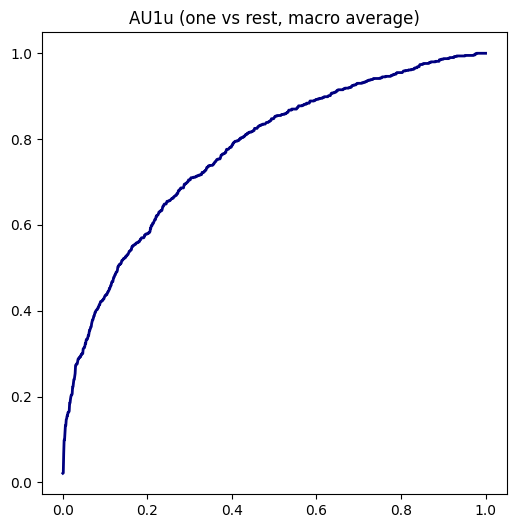

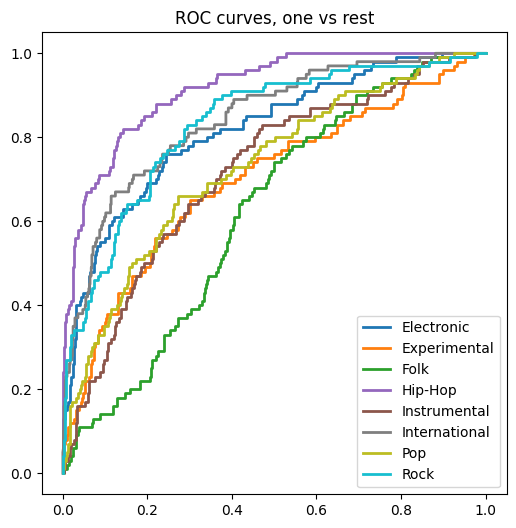

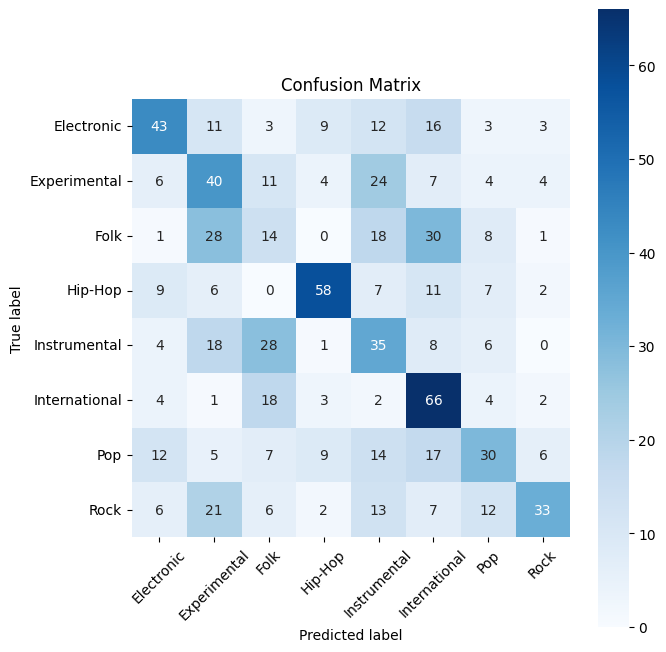

In [142]:
write_results_report_to_new_file(report_output_dirs['fma_small_multi'], EPOCHS_FMA_SMALL_MULTI, results_fma_small, fma_small_top_classes)

# Create FMA-medium DataLoaders

With val

In [42]:
BATCH_SIZE = 32
CHANNELS = 3

In [48]:
fma_medium_train_dl = prepare_dataloader_based_on_df(fma_medium_train_df, fma_medium_top_classes, BATCH_SIZE, CHANNELS)
fma_medium_val_dl = prepare_dataloader_based_on_df(fma_medium_val_df, fma_medium_top_classes, BATCH_SIZE, CHANNELS)
fma_medium_test_dl = prepare_dataloader_based_on_df(fma_medium_test_df, fma_medium_top_classes, BATCH_SIZE, CHANNELS)

# Create and train FMA-medium model

In [99]:
EPOCHS_FMA_MEDIUM_MULTI = 5

In [94]:
model_fma_medium = CNN(img_size=IMAGE_SIZE, channels=CHANNELS, num_outputs=len(fma_medium_top_classes)).to(device)

In [95]:
fma_medium_basic_multiclass_metrics = create_basic_multiclass_metrics(num_classes=len(fma_medium_top_classes))
fma_medium_full_multiclass_metrics = create_full_multiclass_metrics(num_classes=len(fma_medium_top_classes))

TRAINING=======
[EPOCH 1], LOSS: 1.731150497960891
macro_accuracy: 0.9345
macro_recall: 0.2309
macro_precision: 0.2343
macro_f1: 0.2282
precision_per_class: Electronic: 0.4669 Experimental: 0.2750 Folk: 0.3702 Hip-Hop: 0.3739 Instrumental: 0.2569 International: 0.2510 Pop: 0.0564 Rock: 0.6021 Easy Listening: 0.0000 Blues: 0.0000 Soul-RnB: 0.0000 Spoken: 0.0000 Country: 0.0000 Jazz: 0.0000 Old-Time / Historic: 0.7659 Classical: 0.3303 
recall_per_class: Electronic: 0.6198 Experimental: 0.1678 Folk: 0.3781 Hip-Hop: 0.3248 Instrumental: 0.1782 International: 0.1499 Pop: 0.0116 Rock: 0.7431 Easy Listening: 0.0000 Blues: 0.0000 Soul-RnB: 0.0000 Spoken: 0.0000 Country: 0.0000 Jazz: 0.0000 Old-Time / Historic: 0.8260 Classical: 0.2949 
VALIDATION=======


        [ 8],
        [ 9],
        [10],
        [11],
        [12],
        [13]], device='cuda:0') classes have zero instances in both the predictions and the ground truth labels. Precision is still logged as zero.


macro_accuracy: 0.9388
macro_recall: 0.1739
macro_precision: 0.3155
macro_f1: 0.1770
precision_per_class: Electronic: 0.5412 Experimental: 0.2490 Folk: 0.6087 Hip-Hop: 0.2697 Instrumental: 0.1613 International: 1.0000 Pop: 0.0000 Rock: 0.5812 Easy Listening: 0.0000 Blues: 0.0000 Soul-RnB: 0.0000 Spoken: 0.0000 Country: 0.0000 Jazz: 0.0000 Old-Time / Historic: 1.0000 Classical: 0.6364 
recall_per_class: Electronic: 0.7908 Experimental: 0.2756 Folk: 0.0921 Hip-Hop: 0.1091 Instrumental: 0.1145 International: 0.0196 Pop: 0.0000 Rock: 0.8959 Easy Listening: 0.0000 Blues: 0.0000 Soul-RnB: 0.0000 Spoken: 0.0000 Country: 0.0000 Jazz: 0.0000 Old-Time / Historic: 0.3725 Classical: 0.1129 


        [ 9],
        [10]], device='cuda:0') classes have zero instances in both the predictions and the ground truth labels. Precision is still logged as zero.


TRAINING=======
[EPOCH 2], LOSS: 1.3745584008778022
macro_accuracy: 0.9466
macro_recall: 0.3100
macro_precision: 0.3298
macro_f1: 0.3076
precision_per_class: Electronic: 0.5828 Experimental: 0.3862 Folk: 0.4646 Hip-Hop: 0.5325 Instrumental: 0.3553 International: 0.3833 Pop: 0.0930 Rock: 0.6583 Easy Listening: 0.0000 Blues: 0.0000 Soul-RnB: 0.0000 Spoken: 0.2821 Country: 0.0000 Jazz: 0.1429 Old-Time / Historic: 0.8904 Classical: 0.5056 
recall_per_class: Electronic: 0.7258 Experimental: 0.2639 Folk: 0.5453 Hip-Hop: 0.5046 Instrumental: 0.2375 International: 0.2420 Pop: 0.0085 Rock: 0.8094 Easy Listening: 0.0000 Blues: 0.0000 Soul-RnB: 0.0000 Spoken: 0.1170 Country: 0.0000 Jazz: 0.0033 Old-Time / Historic: 0.9559 Classical: 0.5475 
VALIDATION=======


        [ 8],
        [ 9],
        [10],
        [12]], device='cuda:0') classes have zero instances in both the predictions and the ground truth labels. Precision is still logged as zero.


macro_accuracy: 0.9493
macro_recall: 0.3198
macro_precision: 0.3573
macro_f1: 0.3092
precision_per_class: Electronic: 0.6170 Experimental: 0.4302 Folk: 0.3918 Hip-Hop: 0.5036 Instrumental: 0.1753 International: 0.6667 Pop: 0.0000 Rock: 0.7617 Easy Listening: 0.0000 Blues: 0.0000 Soul-RnB: 0.0000 Spoken: 0.5000 Country: 0.0000 Jazz: 0.1379 Old-Time / Historic: 0.8261 Classical: 0.7069 
recall_per_class: Electronic: 0.7813 Experimental: 0.1644 Folk: 0.7500 Hip-Hop: 0.6364 Instrumental: 0.1298 International: 0.1373 Pop: 0.0000 Rock: 0.8228 Easy Listening: 0.0000 Blues: 0.0000 Soul-RnB: 0.0000 Spoken: 0.0833 Country: 0.0000 Jazz: 0.2051 Old-Time / Historic: 0.7451 Classical: 0.6613 


        [9]], device='cuda:0') classes have zero instances in both the predictions and the ground truth labels. Precision is still logged as zero.


TRAINING=======
[EPOCH 3], LOSS: 1.284994166763649
macro_accuracy: 0.9500
macro_recall: 0.3419
macro_precision: 0.3783
macro_f1: 0.3428
precision_per_class: Electronic: 0.6106 Experimental: 0.4234 Folk: 0.4993 Hip-Hop: 0.5880 Instrumental: 0.3966 International: 0.3943 Pop: 0.2913 Rock: 0.6795 Easy Listening: 0.0000 Blues: 0.0000 Soul-RnB: 0.0000 Spoken: 0.3836 Country: 0.0833 Jazz: 0.2333 Old-Time / Historic: 0.9282 Classical: 0.5407 
recall_per_class: Electronic: 0.7530 Experimental: 0.2994 Folk: 0.5643 Hip-Hop: 0.5571 Instrumental: 0.2883 International: 0.2727 Pop: 0.0317 Rock: 0.8214 Easy Listening: 0.0000 Blues: 0.0000 Soul-RnB: 0.0000 Spoken: 0.2979 Country: 0.0070 Jazz: 0.0229 Old-Time / Historic: 0.9510 Classical: 0.6040 
VALIDATION=======


        [ 9],
        [10],
        [11],
        [12]], device='cuda:0') classes have zero instances in both the predictions and the ground truth labels. Precision is still logged as zero.


macro_accuracy: 0.9443
macro_recall: 0.3232
macro_precision: 0.2998
macro_f1: 0.2975
precision_per_class: Electronic: 0.6959 Experimental: 0.3987 Folk: 0.3168 Hip-Hop: 0.4597 Instrumental: 0.1860 International: 0.2057 Pop: 0.0968 Rock: 0.8047 Easy Listening: 0.0000 Blues: 0.0000 Soul-RnB: 0.0000 Spoken: 0.0000 Country: 0.0000 Jazz: 0.1053 Old-Time / Historic: 0.9268 Classical: 0.6000 
recall_per_class: Electronic: 0.5911 Experimental: 0.2800 Folk: 0.8421 Hip-Hop: 0.6227 Instrumental: 0.1221 International: 0.3529 Pop: 0.0246 Rock: 0.7651 Easy Listening: 0.0000 Blues: 0.0000 Soul-RnB: 0.0000 Spoken: 0.0000 Country: 0.0000 Jazz: 0.0513 Old-Time / Historic: 0.7451 Classical: 0.7742 


        [ 9],
        [10]], device='cuda:0') classes have zero instances in both the predictions and the ground truth labels. Precision is still logged as zero.


TRAINING=======
[EPOCH 4], LOSS: 1.2270740060752612
macro_accuracy: 0.9521
macro_recall: 0.3589
macro_precision: 0.3990
macro_f1: 0.3639
precision_per_class: Electronic: 0.6240 Experimental: 0.4486 Folk: 0.5268 Hip-Hop: 0.6464 Instrumental: 0.4090 International: 0.4344 Pop: 0.1732 Rock: 0.6879 Easy Listening: 0.0000 Blues: 0.0000 Soul-RnB: 0.0000 Spoken: 0.4688 Country: 0.0667 Jazz: 0.3462 Old-Time / Historic: 0.9537 Classical: 0.5985 
recall_per_class: Electronic: 0.7645 Experimental: 0.3444 Folk: 0.5914 Hip-Hop: 0.5947 Instrumental: 0.2969 International: 0.3133 Pop: 0.0233 Rock: 0.8261 Easy Listening: 0.0000 Blues: 0.0000 Soul-RnB: 0.0000 Spoken: 0.3191 Country: 0.0070 Jazz: 0.0588 Old-Time / Historic: 0.9583 Classical: 0.6444 
VALIDATION=======


        [ 9],
        [10],
        [12]], device='cuda:0') classes have zero instances in both the predictions and the ground truth labels. Precision is still logged as zero.


macro_accuracy: 0.9468
macro_recall: 0.2572
macro_precision: 0.4337
macro_f1: 0.2814
precision_per_class: Electronic: 0.5778 Experimental: 0.3670 Folk: 0.6154 Hip-Hop: 0.6555 Instrumental: 0.1203 International: 0.6500 Pop: 0.1429 Rock: 0.6480 Easy Listening: 0.0000 Blues: 0.0000 Soul-RnB: 0.0000 Spoken: 1.0000 Country: 0.0000 Jazz: 0.2500 Old-Time / Historic: 1.0000 Classical: 0.9130 
recall_per_class: Electronic: 0.8067 Experimental: 0.3067 Folk: 0.2632 Hip-Hop: 0.3545 Instrumental: 0.1450 International: 0.1275 Pop: 0.0082 Rock: 0.9114 Easy Listening: 0.0000 Blues: 0.0000 Soul-RnB: 0.0000 Spoken: 0.0833 Country: 0.0000 Jazz: 0.0256 Old-Time / Historic: 0.7451 Classical: 0.3387 


TRAINING=======
[EPOCH 5], LOSS: 1.174964959742172
macro_accuracy: 0.9534
macro_recall: 0.3751
macro_precision: 0.4866
macro_f1: 0.3839
precision_per_class: Electronic: 0.6357 Experimental: 0.4676 Folk: 0.5506 Hip-Hop: 0.6487 Instrumental: 0.4135 International: 0.4801 Pop: 0.2538 Rock: 0.6966 Easy Listening: 0.0000 Blues: 1.0000 Soul-RnB: 0.0000 Spoken: 0.4615 Country: 0.2692 Jazz: 0.3231 Old-Time / Historic: 0.9588 Classical: 0.6268 
recall_per_class: Electronic: 0.7718 Experimental: 0.3533 Folk: 0.5964 Hip-Hop: 0.6039 Instrumental: 0.3161 International: 0.3563 Pop: 0.0529 Rock: 0.8273 Easy Listening: 0.0000 Blues: 0.0172 Soul-RnB: 0.0000 Spoken: 0.3191 Country: 0.0493 Jazz: 0.0686 Old-Time / Historic: 0.9706 Classical: 0.6990 
VALIDATION=======


        [ 9],
        [10]], device='cuda:0') classes have zero instances in both the predictions and the ground truth labels. Precision is still logged as zero.
C:\Users\Operator\AppData\Local\Temp\ipykernel_21656\1215925936.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)


macro_accuracy: 0.9405
micro_accuracy: 0.9405
accuracy_per_class: Electronic: 0.7396 Experimental: 0.9042 Folk: 0.9357 Hip-Hop: 0.8834 Instrumental: 0.9453 International: 0.9493 Pop: 0.9457 Rock: 0.8191 Easy Listening: 0.9992 Blues: 0.9968 Soul-RnB: 0.9928 Spoken: 0.9892 Country: 0.9920 Jazz: 0.9820 Old-Time / Historic: 0.9948 Classical: 0.9788 
macro_f1: 0.3061
micro_f1: 0.5240
f1_per_class: Electronic: 0.6072 Experimental: 0.2547 Folk: 0.5465 Hip-Hop: 0.5290 Instrumental: 0.0927 International: 0.3923 Pop: 0.0145 Rock: 0.6112 Easy Listening: 0.0000 Blues: 0.0000 Soul-RnB: 0.0000 Spoken: 0.2703 Country: 0.0000 Jazz: 0.0426 Old-Time / Historic: 0.8571 Classical: 0.6788 
macro_precision: 0.3265
micro_precision: 0.5240
precision_per_class: Electronic: 0.4898 Experimental: 0.4227 Folk: 0.4778 Hip-Hop: 0.4100 Instrumental: 0.3500 International: 0.3832 Pop: 0.0625 Rock: 0.7841 Easy Listening: 0.0000 Blues: 0.0000 Soul-RnB: 0.0000 Spoken: 0.2000 Country: 0.0000 Jazz: 0.1250 Old-Time / Histori

C:\Users\Operator\AppData\Local\Temp\ipykernel_21656\2229845795.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(class_names))


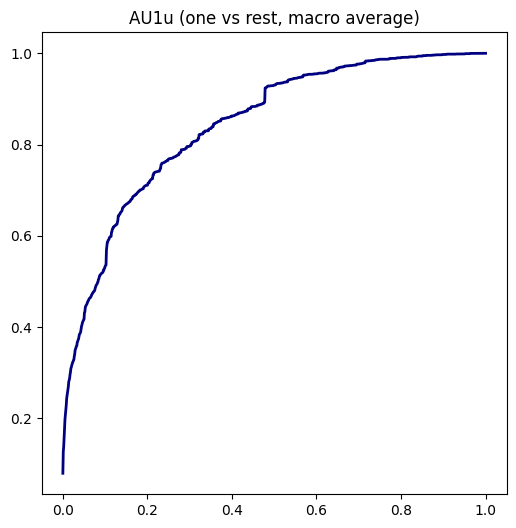

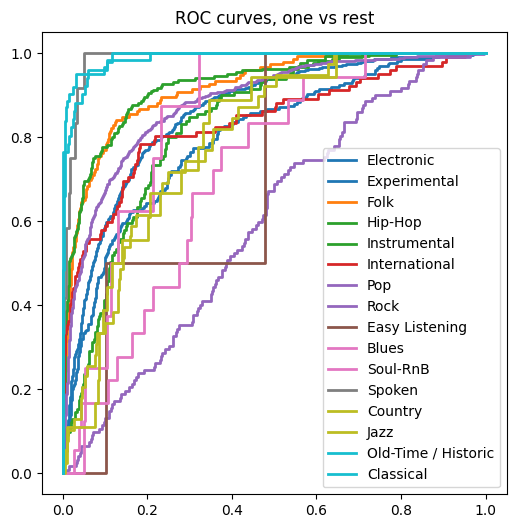

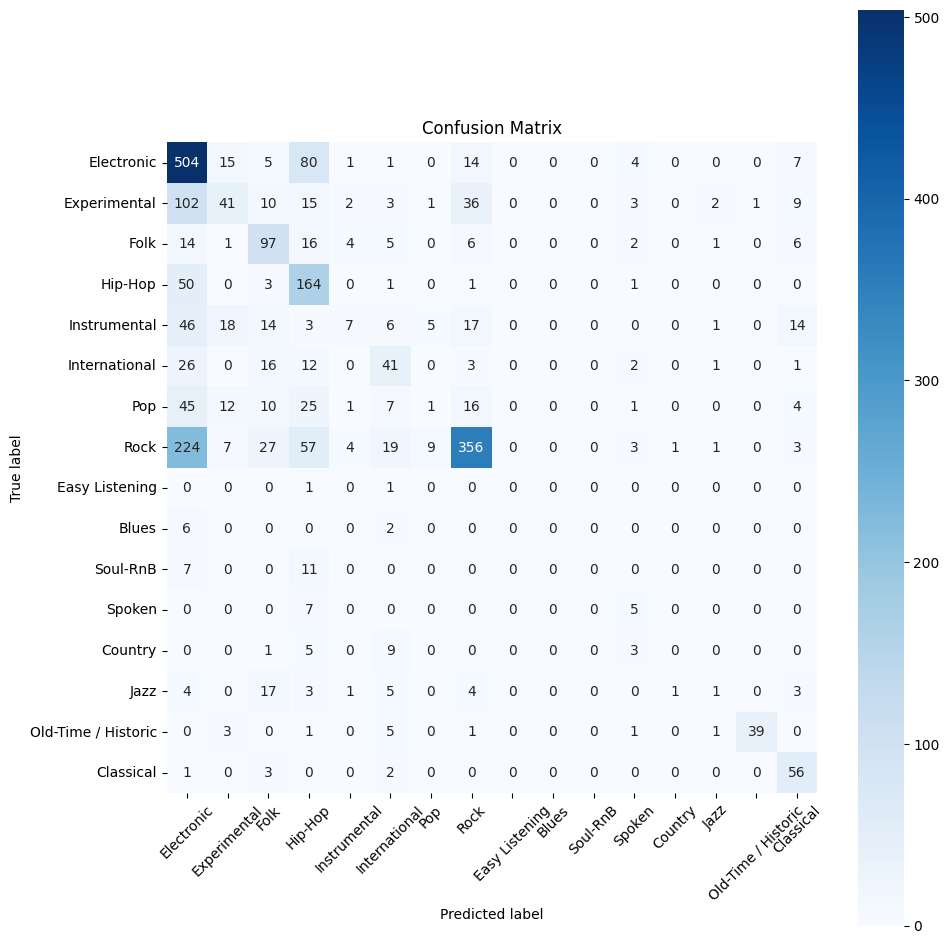

In [100]:
training_loop(model=model_fma_medium,
              epochs=EPOCHS_FMA_MEDIUM_MULTI,
              basic_metrics=fma_medium_basic_multiclass_metrics,
              class_names=fma_medium_top_classes,
              train_dl=fma_medium_train_dl,
              val_dl=fma_medium_val_dl,
              full_metrics=fma_medium_full_multiclass_metrics)

        [ 9],
        [10]], device='cuda:0') classes have zero instances in both the predictions and the ground truth labels. Precision is still logged as zero.
C:\Users\Operator\AppData\Local\Temp\ipykernel_21656\1215925936.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)


macro_accuracy: 0.9378
micro_accuracy: 0.9378
accuracy_per_class: Electronic: 0.7613 Experimental: 0.9086 Folk: 0.8954 Hip-Hop: 0.8927 Instrumental: 0.9296 International: 0.9390 Pop: 0.9467 Rock: 0.8204 Easy Listening: 0.9977 Blues: 0.9969 Soul-RnB: 0.9837 Spoken: 0.9876 Country: 0.9887 Jazz: 0.9841 Old-Time / Historic: 0.9961 Classical: 0.9771 
macro_f1: 0.2912
micro_f1: 0.5027
f1_per_class: Electronic: 0.6233 Experimental: 0.2769 Folk: 0.2670 Hip-Hop: 0.5534 Instrumental: 0.1340 International: 0.3262 Pop: 0.0284 Rock: 0.6105 Easy Listening: 0.0000 Blues: 0.0000 Soul-RnB: 0.0000 Spoken: 0.2727 Country: 0.0000 Jazz: 0.0465 Old-Time / Historic: 0.9107 Classical: 0.6093 
macro_precision: 0.3093
micro_precision: 0.5027
precision_per_class: Electronic: 0.5090 Experimental: 0.4500 Folk: 0.2279 Hip-Hop: 0.4296 Instrumental: 0.4000 International: 0.2901 Pop: 0.0909 Rock: 0.7605 Easy Listening: 0.0000 Blues: 0.0000 Soul-RnB: 0.0000 Spoken: 0.1875 Country: 0.0000 Jazz: 0.2500 Old-Time / Histori

C:\Users\Operator\AppData\Local\Temp\ipykernel_21656\2229845795.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(class_names))


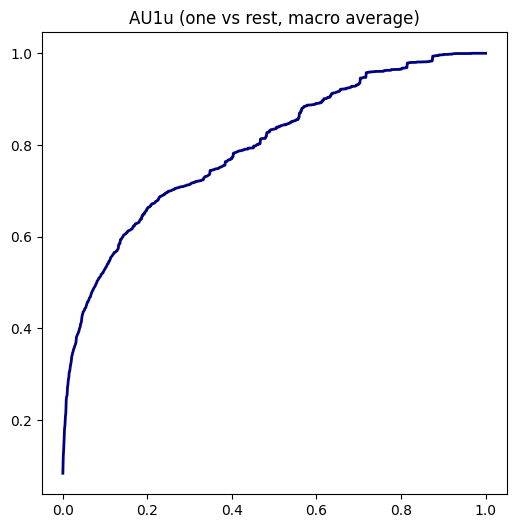

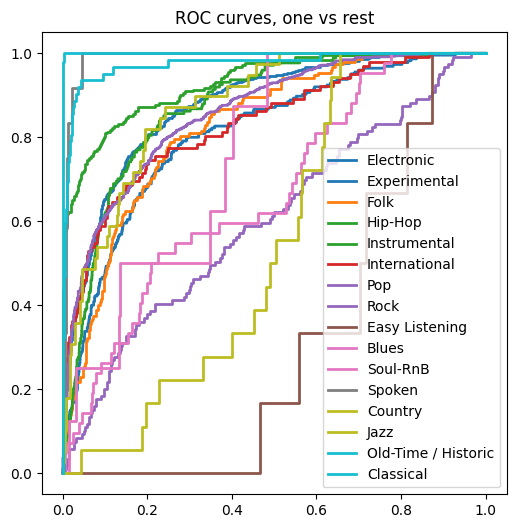

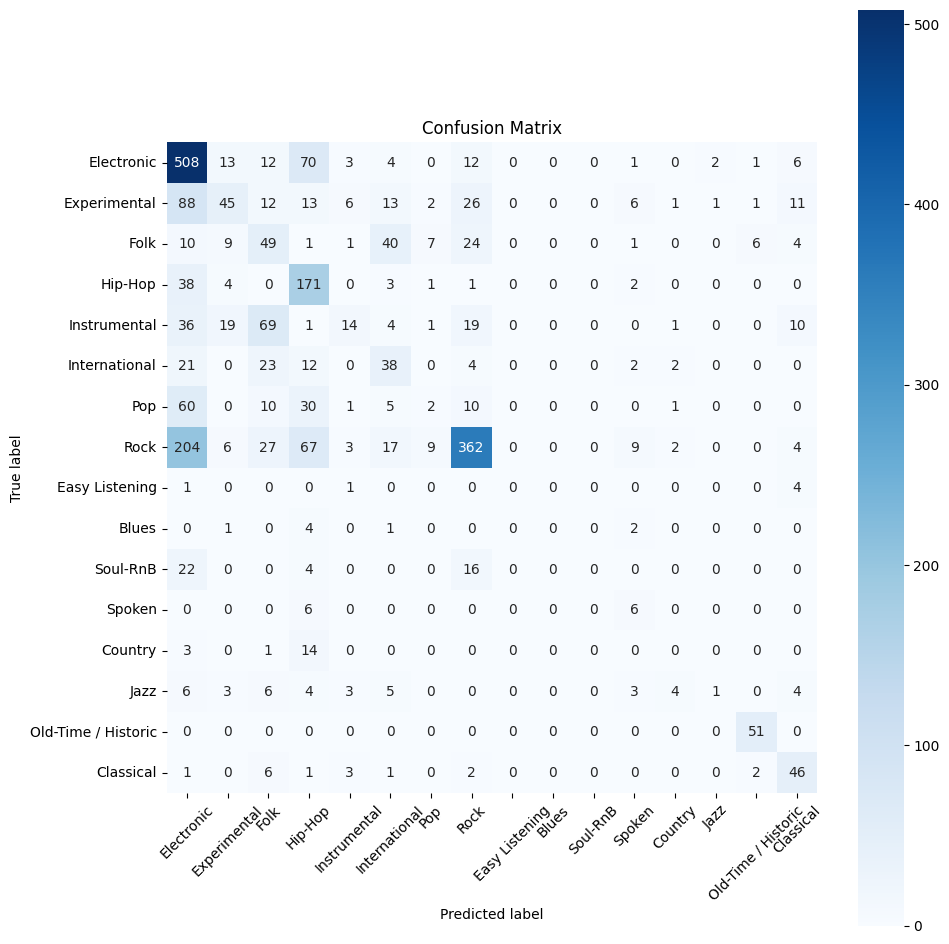

In [101]:
results_fma_medium = test_loop(model_fma_medium, fma_medium_full_multiclass_metrics, fma_medium_top_classes, fma_medium_test_dl)

C:\Users\Operator\AppData\Local\Temp\ipykernel_21656\2229845795.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(class_names))


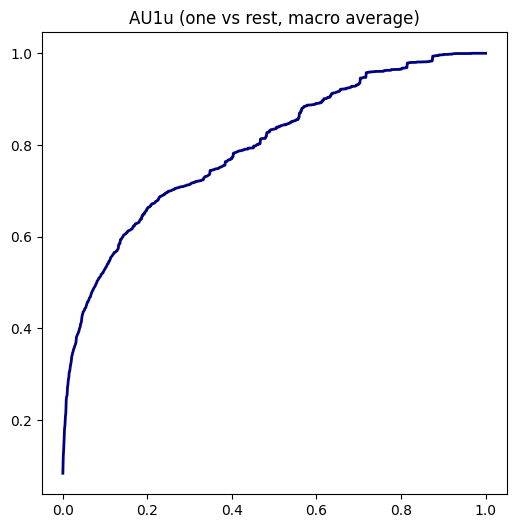

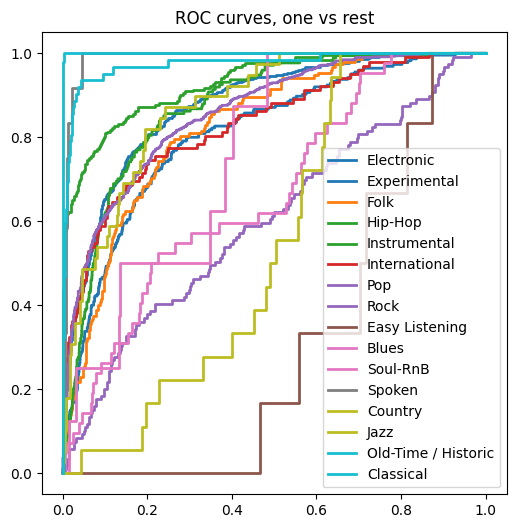

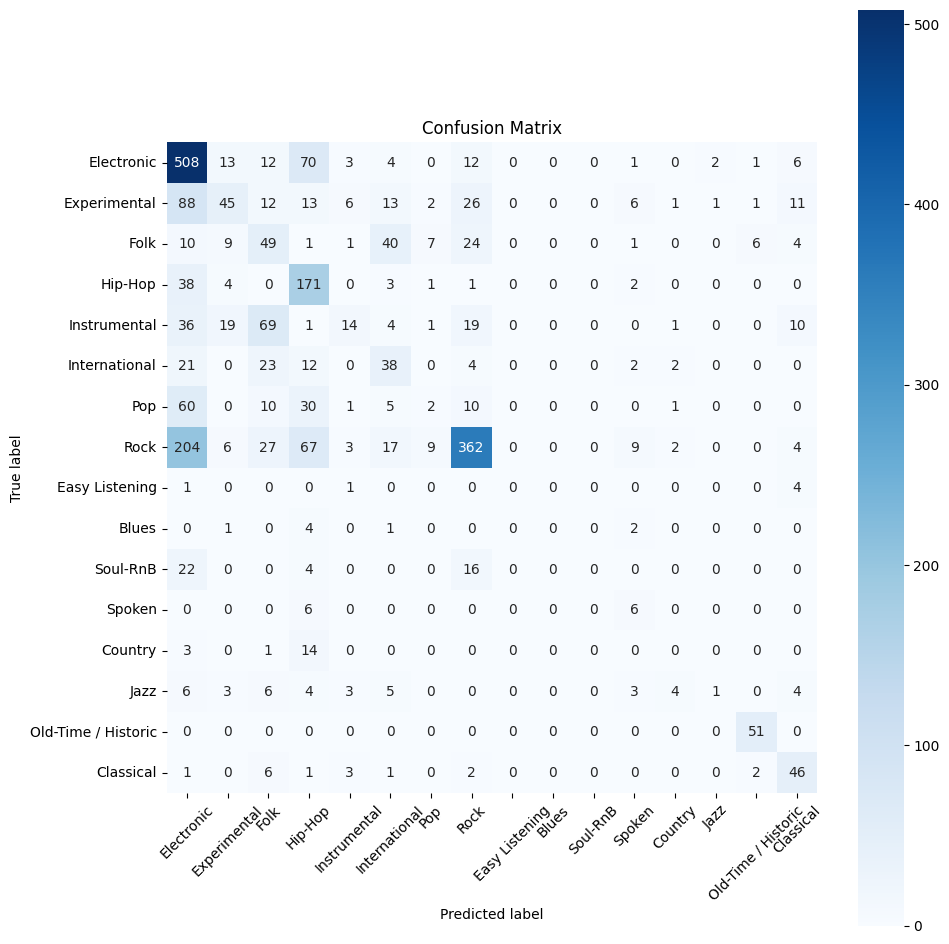

In [102]:
write_results_report_to_new_file(report_output_dirs['fma_medium_multi'], 0, results_fma_medium, fma_medium_top_classes)

# Function definition for binary classification

In [36]:
def trim_dataframe_to_binary_classification(df, class1, class2):
    return df[(df['genre'] == class1) | (df['genre'] == class2)]

# GTZAN binary classification

Best classes: Classical, Pop

In [97]:
EPOCHS_GTZAN_BINARY = 5

In [43]:
BATCH_SIZE = 32
CHANNELS = 3

In [ ]:
GTZAN_CLASS_1 = 'Classical' # Jazz
GTZAN_CLASS_2 = 'Metal'
gtzan_2_classes = [GTZAN_CLASS_1, GTZAN_CLASS_2]

In [45]:
gtzan_2_train_df = trim_dataframe_to_binary_classification(gtzan_train_df, *gtzan_2_classes)
gtzan_2_val_df = trim_dataframe_to_binary_classification(gtzan_val_df,  *gtzan_2_classes)
gtzan_2_test_df = trim_dataframe_to_binary_classification(gtzan_test_df,  *gtzan_2_classes)

In [46]:
gtzan_2_train_dl = prepare_dataloader_based_on_df(gtzan_2_train_df, gtzan_2_classes, BATCH_SIZE, CHANNELS)
gtzan_2_val_dl = prepare_dataloader_based_on_df(gtzan_2_val_df, gtzan_2_classes, BATCH_SIZE, CHANNELS)
gtzan_2_test_dl = prepare_dataloader_based_on_df(gtzan_2_test_df, gtzan_2_classes, BATCH_SIZE, CHANNELS)

In [47]:
model_gtzan_2 = CNN(img_size=IMAGE_SIZE, channels=CHANNELS, num_outputs=1).to(device)

In [48]:
basic_metrics_2 = create_basic_binary_metrics()
full_metrics_2 = create_full_binary_metrics()

In [ ]:
training_loop(model=model_gtzan_2,
              epochs=EPOCHS_GTZAN_BINARY,
              basic_metrics=basic_metrics_2,
              class_names=gtzan_2_classes,
              train_dl=gtzan_2_train_dl,
              val_dl=gtzan_2_val_dl,
              full_metrics=full_metrics_2)

In [ ]:
results_gtzan_2 = test_loop(model_gtzan_2, full_metrics_2, gtzan_2_classes, gtzan_2_test_dl)

In [ ]:
write_results_report_to_new_file(report_output_dirs['gtzan_binary'], EPOCHS_GTZAN_BINARY, results_gtzan_2, gtzan_2_classes)

# FMA-small binary classification

Best classes:

In [58]:
FMA_SMALL_GTZAN_BINARY = 5

In [43]:
BATCH_SIZE = 32
CHANNELS = 3

In [44]:
FMA_SMALL_CLASS_1 = 'Electronic' # International
FMA_SMALL_CLASS_2 = 'Hip-Hop'
fma_small_2_classes = [FMA_SMALL_CLASS_1, FMA_SMALL_CLASS_2]

In [45]:
fma_small_2_train_df = trim_dataframe_to_binary_classification(fma_small_train_df, *fma_small_2_classes)
fma_small_2_val_df = trim_dataframe_to_binary_classification(fma_small_val_df,  *fma_small_2_classes)
fma_small_2_test_df = trim_dataframe_to_binary_classification(fma_small_test_df,  *fma_small_2_classes)

In [46]:
fma_small_2_train_dl = prepare_dataloader_based_on_df(fma_small_2_train_df, fma_small_2_classes, BATCH_SIZE, CHANNELS)
fma_small_2_val_dl = prepare_dataloader_based_on_df(fma_small_2_val_df, fma_small_2_classes, BATCH_SIZE, CHANNELS)
fma_small_2_test_dl = prepare_dataloader_based_on_df(fma_small_2_test_df, fma_small_2_classes, BATCH_SIZE, CHANNELS)

In [55]:
model_fma_small_2 = CNN(img_size=IMAGE_SIZE, channels=CHANNELS, num_outputs=1).to(device)

In [48]:
basic_metrics_2 = create_basic_binary_metrics()
full_metrics_2 = create_full_binary_metrics()

TRAINING=======
[EPOCH 1], LOSS: 0.022785276278154923
accuracy: 0.9912
f1: 0.9912
VALIDATION=======
accuracy: 0.7000
f1: 0.6552
TRAINING=======
[EPOCH 2], LOSS: 0.02846785073954379
accuracy: 0.9893
f1: 0.9893
VALIDATION=======
accuracy: 0.7350
f1: 0.7706
TRAINING=======
[EPOCH 3], LOSS: 0.024333062973746565
accuracy: 0.9900
f1: 0.9900
VALIDATION=======
accuracy: 0.8150
f1: 0.8246
TRAINING=======
[EPOCH 4], LOSS: 0.029028931225766427
accuracy: 0.9919
f1: 0.9918
VALIDATION=======
accuracy: 0.7000
f1: 0.7500
TRAINING=======
[EPOCH 5], LOSS: 0.05520966805546777
accuracy: 0.9793
f1: 0.9793
VALIDATION=======
accuracy: 0.7400
f1: 0.7759
precision: 0.6818
recall: 0.9000
cohen's kappa: 0.4800
MCC: 0.5066
MSE: 0.2394
LogLoss: 2.5648
binary_ROC-AUC: 0.8286


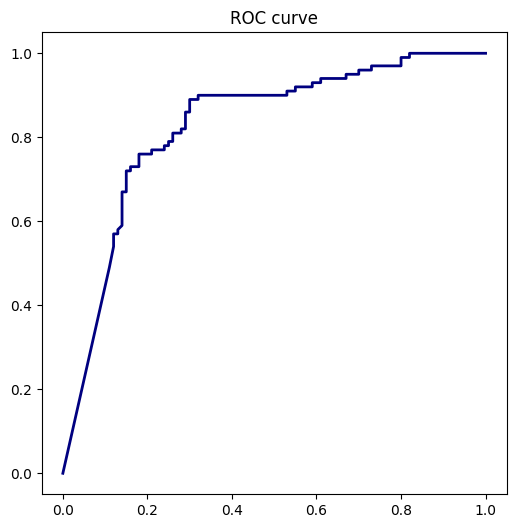

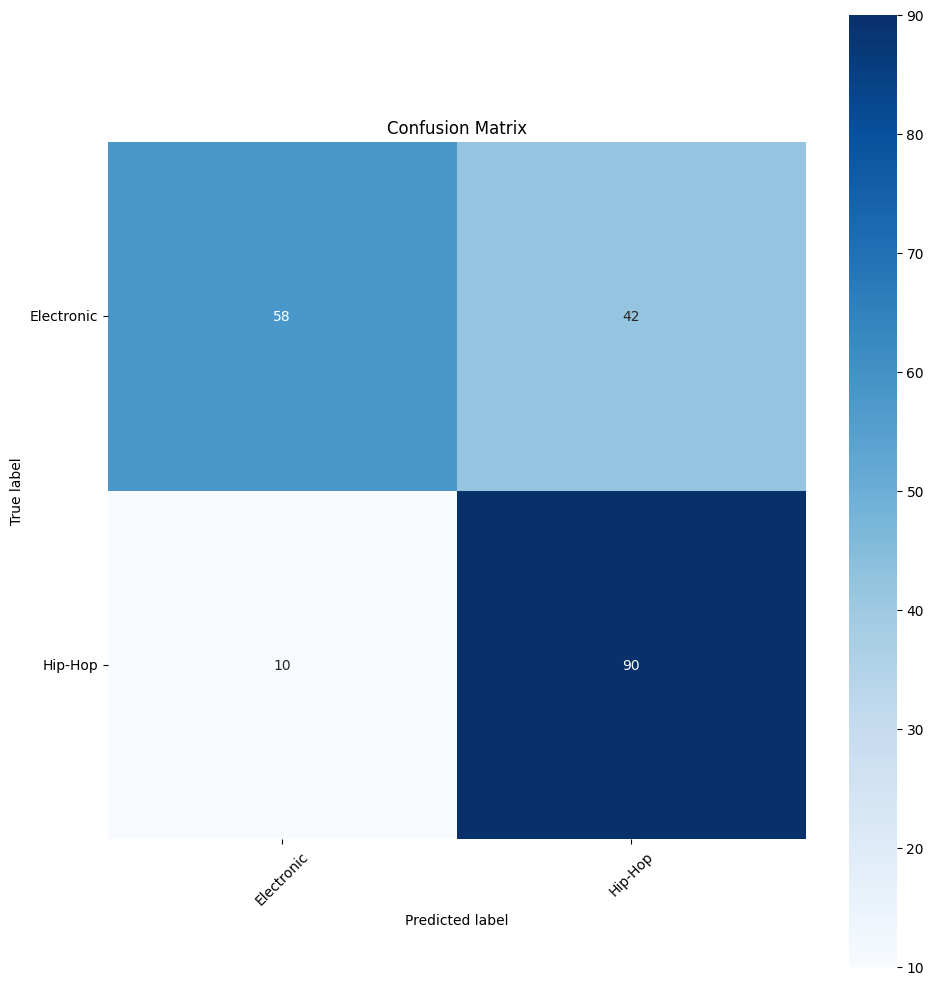

In [88]:
training_loop(model=model_fma_small_2,
              epochs=FMA_SMALL_GTZAN_BINARY,
              basic_metrics=basic_metrics_2,
              class_names=fma_small_2_classes,
              train_dl=fma_small_2_train_dl,
              val_dl=fma_small_2_val_dl,
              full_metrics=full_metrics_2)

accuracy: 0.6950
f1: 0.7530
precision: 0.6327
recall: 0.9300
cohen's kappa: 0.3900
MCC: 0.4418
MSE: 0.2743
LogLoss: 2.5723
binary_ROC-AUC: 0.8679


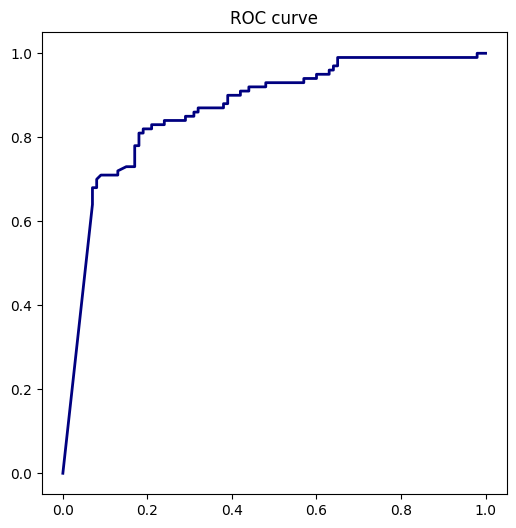

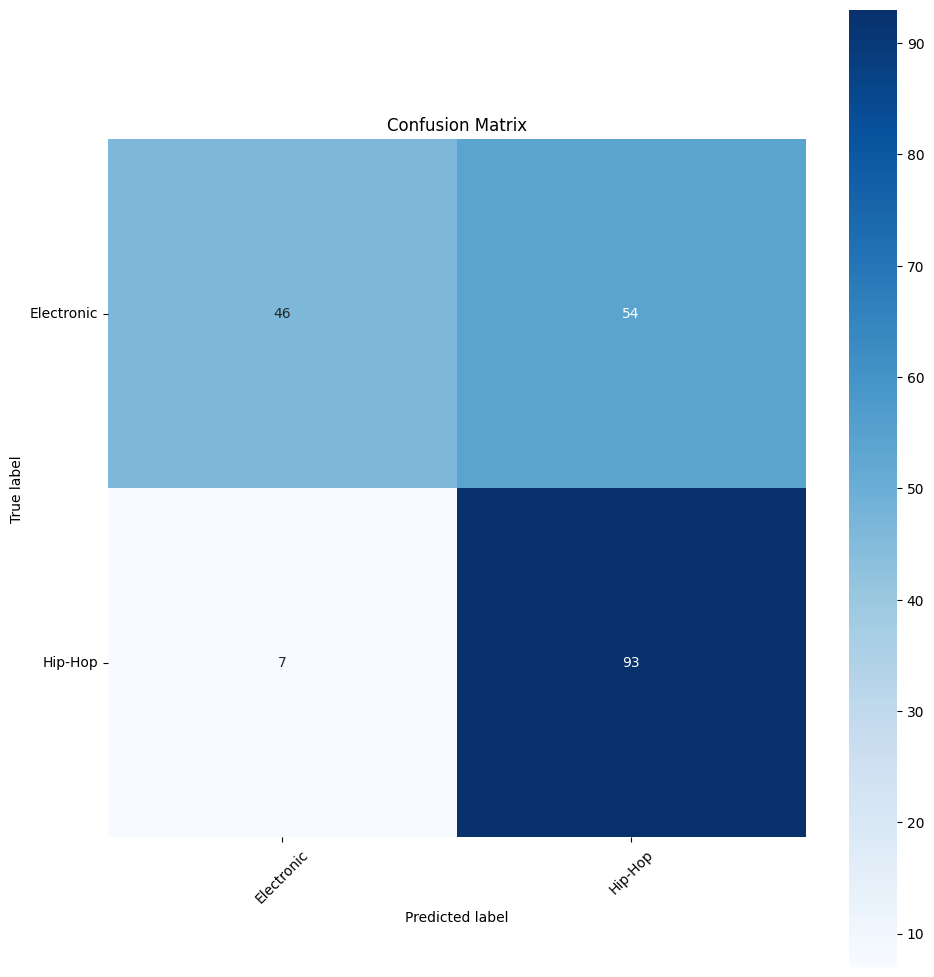

In [89]:
results_fma_small_2 = test_loop(model_fma_small_2, full_metrics_2, fma_small_2_classes, fma_small_2_test_dl)

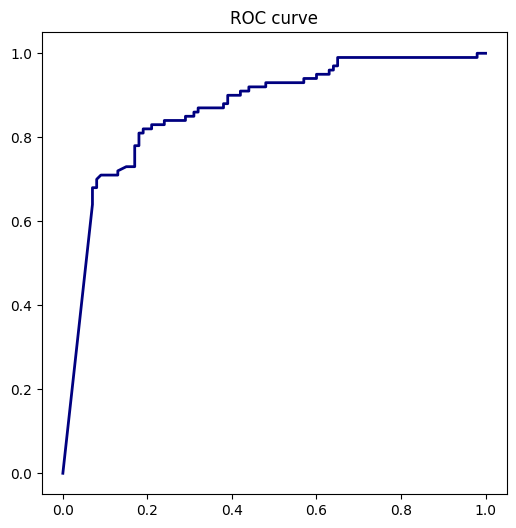

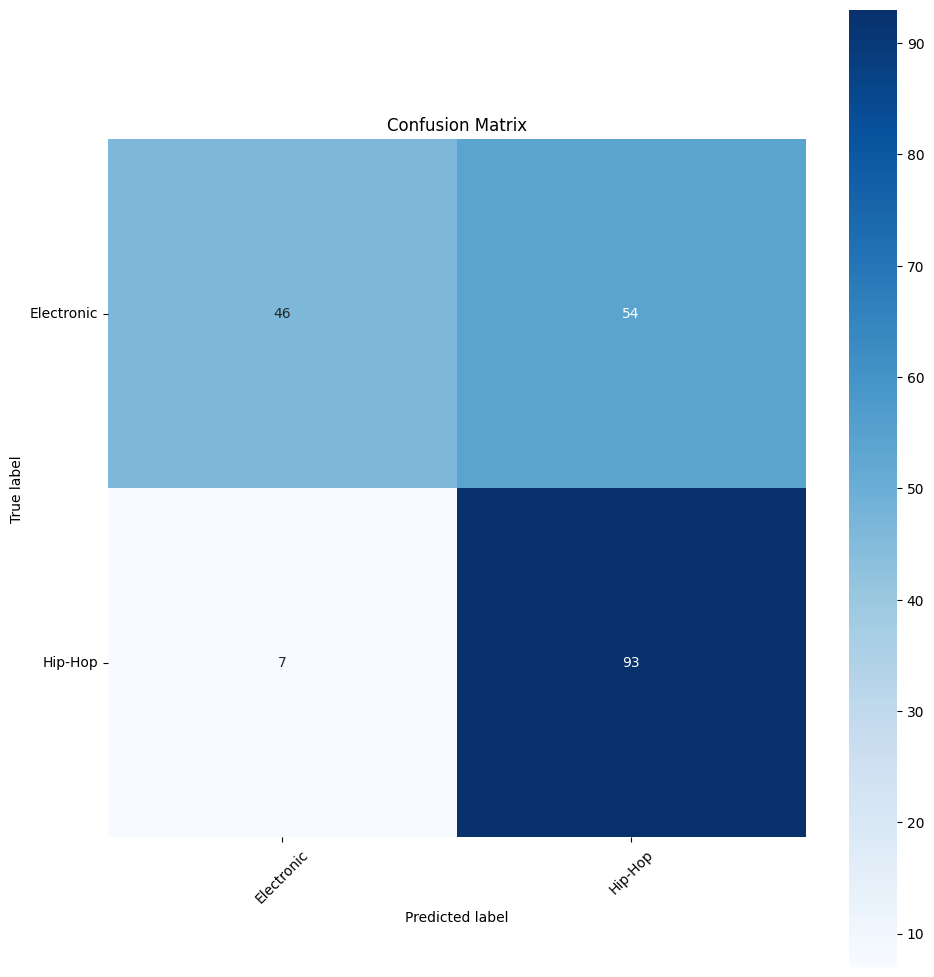

In [90]:
write_results_report_to_new_file(report_output_dirs['fma_small_binary'], FMA_SMALL_GTZAN_BINARY, results_fma_small_2, fma_small_2_classes)

# FMA-medium binary classification

In [54]:
FMA_MEDIUM_GTZAN_BINARY = 5

In [38]:
BATCH_SIZE = 32
CHANNELS = 3

In [39]:
FMA_MEDIUM_CLASS_1 = 'Electronic'
FMA_MEDIUM_CLASS_2 = 'Rock'
fma_medium_2_classes = [FMA_MEDIUM_CLASS_1, FMA_MEDIUM_CLASS_2]

In [40]:
fma_medium_2_train_df = trim_dataframe_to_binary_classification(fma_medium_train_df, *fma_medium_2_classes)
fma_medium_2_val_df = trim_dataframe_to_binary_classification(fma_medium_val_df,  *fma_medium_2_classes)
fma_medium_2_test_df = trim_dataframe_to_binary_classification(fma_medium_test_df,  *fma_medium_2_classes)

In [49]:
fma_medium_2_train_dl = prepare_dataloader_based_on_df(fma_medium_2_train_df, fma_medium_2_classes, BATCH_SIZE, CHANNELS)
fma_medium_2_val_dl = prepare_dataloader_based_on_df(fma_medium_2_val_df, fma_medium_2_classes, BATCH_SIZE, CHANNELS)
fma_medium_2_test_dl = prepare_dataloader_based_on_df(fma_medium_2_test_df, fma_medium_2_classes, BATCH_SIZE, CHANNELS)

In [50]:
model_fma_medium_2 = CNN(img_size=IMAGE_SIZE, channels=CHANNELS, num_outputs=1).to(device)

In [51]:
basic_metrics_2 = create_basic_binary_metrics()
full_metrics_2 = create_full_binary_metrics()

TRAINING=======
[EPOCH 1], LOSS: 0.02817298969871661
accuracy: 0.9903
f1: 0.9908
VALIDATION=======
accuracy: 0.8905
f1: 0.8949
TRAINING=======
[EPOCH 2], LOSS: 0.03481898832420224
accuracy: 0.9880
f1: 0.9886
VALIDATION=======
accuracy: 0.8875
f1: 0.8972
TRAINING=======
[EPOCH 3], LOSS: 0.016888781556796555
accuracy: 0.9938
f1: 0.9942
VALIDATION=======
accuracy: 0.8770
f1: 0.8890
TRAINING=======
[EPOCH 4], LOSS: 0.030131073925206562
accuracy: 0.9894
f1: 0.9899
VALIDATION=======
accuracy: 0.8934
f1: 0.9012
TRAINING=======
[EPOCH 5], LOSS: 0.0269423102584131
accuracy: 0.9906
f1: 0.9911
VALIDATION=======
accuracy: 0.8897
f1: 0.8972
precision: 0.8861
recall: 0.9086
cohen's kappa: 0.7783
MCC: 0.7786
MSE: 0.0912
LogLoss: 0.5585
binary_ROC-AUC: 0.9551


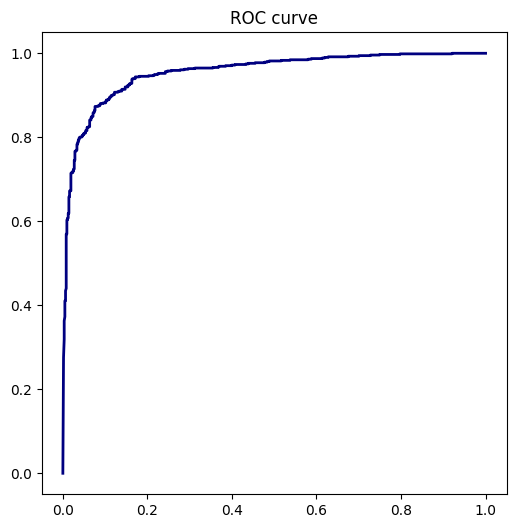

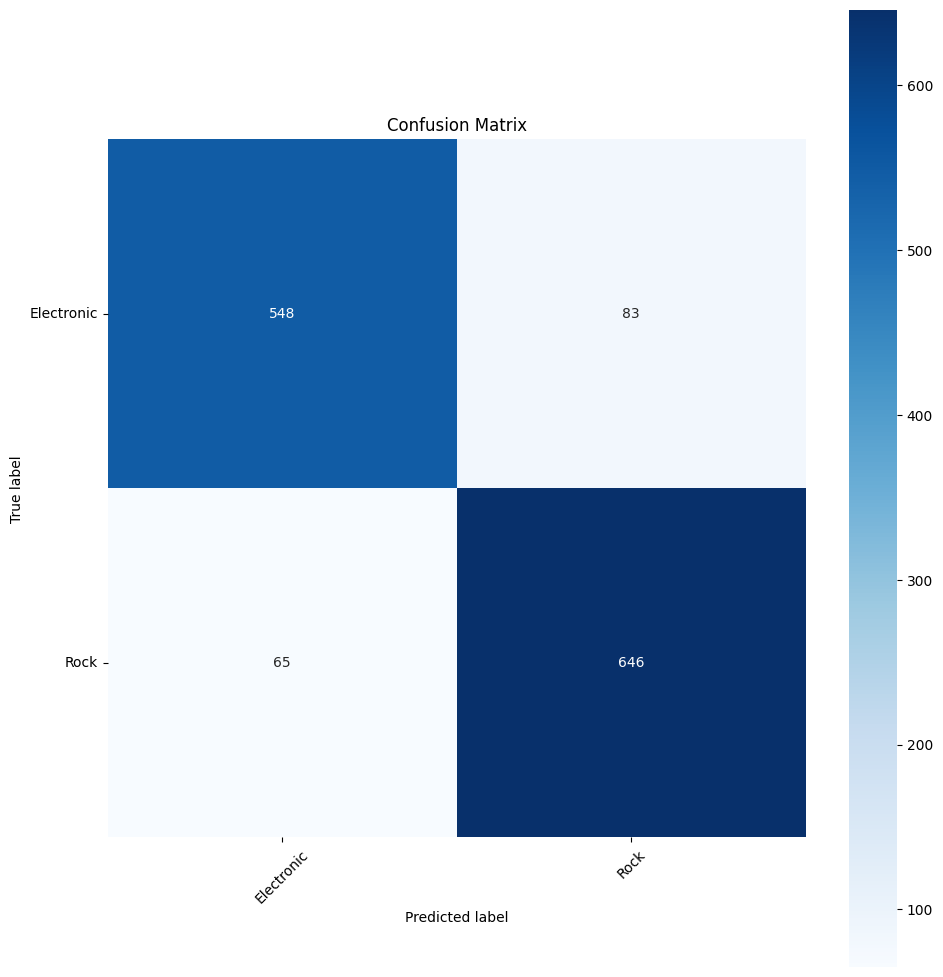

In [76]:
training_loop(model=model_fma_medium_2,
              epochs=FMA_MEDIUM_GTZAN_BINARY,
              basic_metrics=basic_metrics_2,
              class_names=fma_medium_2_classes,
              train_dl=fma_medium_2_train_dl,
              val_dl=fma_medium_2_val_dl,
              full_metrics=full_metrics_2)

accuracy: 0.8949
f1: 0.9027
precision: 0.8850
recall: 0.9211
cohen's kappa: 0.7886
MCC: 0.7894
MSE: 0.0906
LogLoss: 0.5656
binary_ROC-AUC: 0.9555


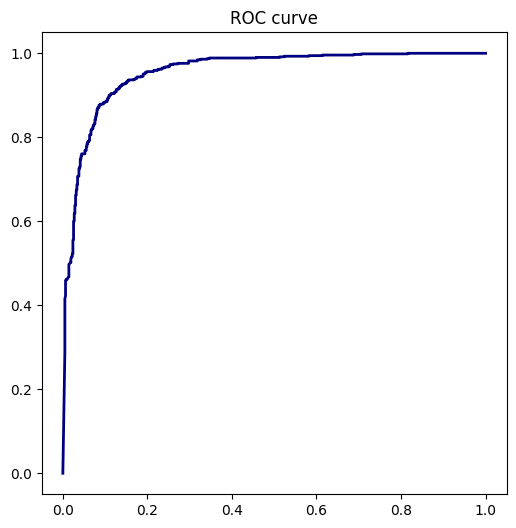

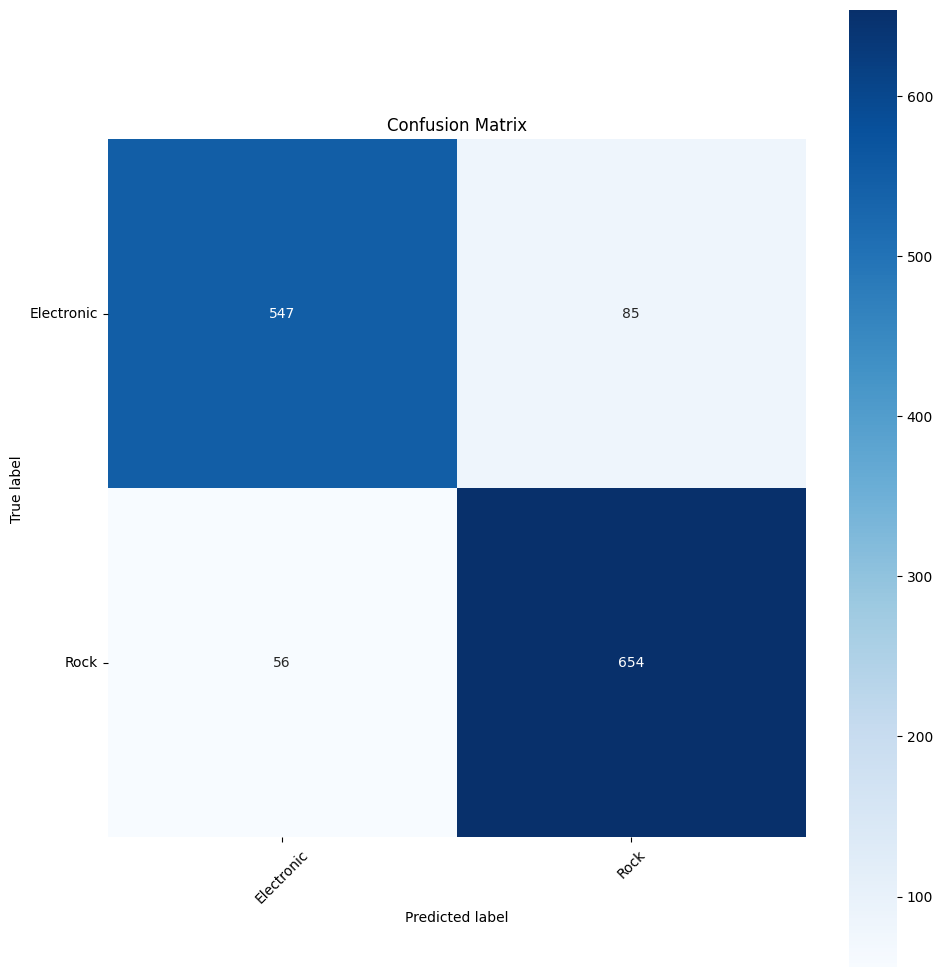

In [77]:
results_fma_medium_2 = test_loop(model_fma_medium_2, full_metrics_2, fma_medium_2_classes, fma_medium_2_test_dl)

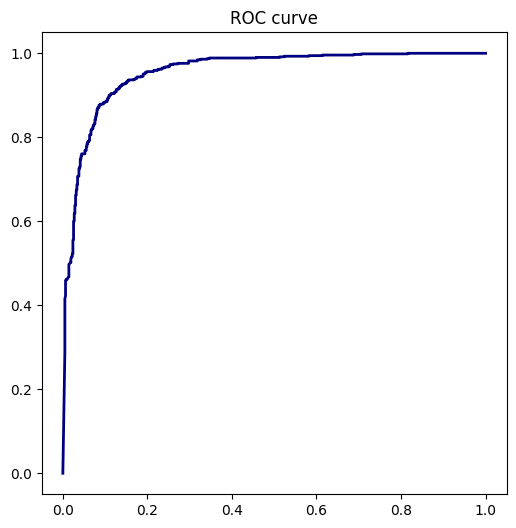

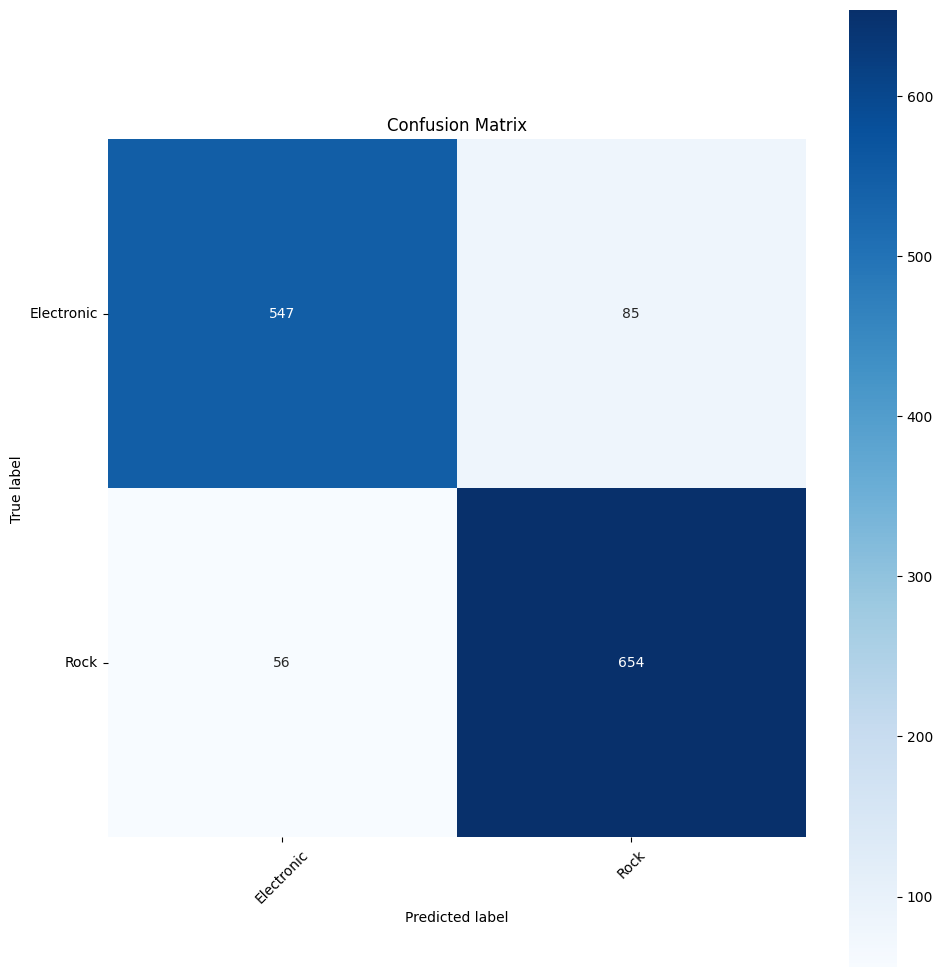

In [78]:
write_results_report_to_new_file(report_output_dirs['fma_medium_binary'], FMA_MEDIUM_GTZAN_BINARY, results_fma_medium_2, fma_medium_2_classes)